# Finding interrelations of the UN SDG Targets and impute missing observations

### This project is divided into two major phases: 
1. It is intended to find cliques within the [UN SDG](https://sustainabledevelopment.un.org/?menu=1300) Targets.
2. Within one of the found cliques, missing observations of the time-series are inferred

Each Target has at least one quantitatively measurable Indicator associated whose measurements from 1984 to 2017 serve as our data points. The data set we are working with is for the entire world, i.e. the values presented are means over all countries. Regarding the first phase, for a more sophisticated analysis, but out of scope of this course, correlations in each country should be analysed separately.

<img src="Screenshot from 2018-04-19 10-08-40.png">

## 1. Find cliques

Import necessary packages and load our preprocessed data set

*if you want to see what happened in the preprocessing, see **prepare_df_for_analysis.ipynb** *

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pystan
import math
import os

In [2]:
# load csv
df = pd.read_csv("TargetsForAnalysis.csv")
df.head()

,Unnamed: 0,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,1984,1985,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,106,Population,Proportion of population below the internation...,1,1.1,1.1.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10.7,NaN,NaN,NaN,NaN
1,107,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.17,NaN
2,108,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.86,NaN
3,109,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.79,NaN
4,110,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.08,NaN


See how many data points we have for each Indicator

In [3]:
intyears = list(range(1984, 2018))
#print(intyears)

years = []
for year in intyears:
    years.append(str(year))
    
#print(years)

In [4]:
def getnumberofyearswithdata(r):
    n = 0
    for year in years:
        if ~np.isnan(r[year]):
            n+=1
    return n

In [5]:
# new column with number of data points per Indicator
df['Years with values'] = df.apply(getnumberofyearswithdata, axis=1)

In [6]:
df.head()
df.shape

(197, 43)

We need at least two data points to conclude any kind of correlation

In [7]:
df_new = df.loc[df['Years with values'] > 1]

# see how many rows we deleted
print(df_new.shape)
df_new.head()

(120, 43)


,Unnamed: 0,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,1984,1985,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Years with values
0,106,Population,Proportion of population below the internation...,1,1.1,1.1.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,10.70,NaN,NaN,NaN,NaN,2
8,115,Population,Proportion of births attended by skilled healt...,3,3.1,3.1.2,Percent,Units,NaN,NaN,...,NaN,69.88,NaN,NaN,NaN,NaN,NaN,78.49,NaN,3
9,129,Population,Participation rate in organized learning (one ...,4,4.2,4.2.2,Percent,Units,NaN,NaN,...,59.41,60.44,62.64,64.64,65.20,66.59,NaN,NaN,NaN,12
10,130,Population,Proportion of population using safely managed ...,6,6.1,6.1.1,Percent,Units,NaN,NaN,...,54.02,55.55,55.91,55.77,55.22,55.03,54.81,NaN,NaN,16
11,131,Population,Proportion of population using safely managed ...,6,6.1,6.1.1,Percent,Units,NaN,NaN,...,69.90,70.82,71.14,71.22,71.09,71.14,71.16,NaN,NaN,16


See how many Targets are associated with the Indicators we found

In [8]:
# create a list of Targets
e = list(df_new['Target'])
type(e[2])

str

In [9]:
df_new['Target'] = df_new.apply(lambda x: str(x['Target']), axis=1)

/Users/GalinaJonat/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [10]:
df_new.shape

(120, 43)

See which Targets are in our data frame

In [11]:
targets = list(set(df_new['Target']))

We know that one Target can have potentially more than one Indicator, and that Indicators can be separetely measured for, e.g., genders, age groups, etc.
But since we want to find interrelations between the Targets, only the row per Target with maximum amount of data is considered.

In [12]:
# create empty dictionary
target_dfs = {}

In [13]:
for t in targets:
    target_dfs[t] = df_new[df_new['Target']==t]

In [14]:
# show an example of Target with more than on Indicator
target_dfs['12.2']

,Unnamed: 0,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,1984,1985,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Years with values
177,77,Environment (Tonnes),"Material footprint, material footprint per cap...",12,12.2,12.2.1,Metric Tons,Units,NaN,NaN,...,9.690000e+00,1.010000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
178,78,Environment (Tonnes),"Material footprint, material footprint per cap...",12,12.2,12.2.1,Metric Tons,Units,NaN,NaN,...,1.330000e-03,1.330000e-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
179,79,Environment (Tonnes),"Material footprint, material footprint per cap...",12,12.2,12.2.1,Metric Tons,Units,NaN,NaN,...,6.573055e+16,6.932903e+16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
183,83,Environment (Tonnes),"Domestic material consumption, domestic materi...",12,12.2,12.2.2,Metric Tons,Units,NaN,NaN,...,9.750000e+00,1.006000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
184,84,Environment (Tonnes),"Domestic material consumption, domestic materi...",12,12.2,12.2.2,Metric Tons,Units,NaN,NaN,...,1.330000e-03,1.330000e-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
185,85,Environment (Tonnes),"Domestic material consumption, domestic materi...",12,12.2,12.2.2,Metric Tons,Units,NaN,NaN,...,6.807354e+16,7.099971e+16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11


In [15]:
# find row with maximum amount of data points for each target
max_dfrows = {}

In [16]:
for target in targets:
    if target_dfs[target].shape[0] > 1:
        max_dfrows[target] = target_dfs[target].loc[target_dfs[target]['Years with values'].idxmax()].to_frame().T
    else:
        max_dfrows[target]=target_dfs[target]

In [17]:
frames = list(max_dfrows[target] for target in targets)

In [18]:
merged_df = pd.concat(frames, axis=0)

In [19]:
units = list(set(merged_df['Unit']))

In [20]:
units.remove('Percent')
units

['Metric Tons', 'USD', 'Constant USD']

In [21]:
not_percent = merged_df[merged_df['Unit'].isin(units)]
not_percent

,Unnamed: 0,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,1984,1985,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Years with values
141,36,E&P (USD),Dollar value of all resources made available t...,17,17.19,17.19.1,USD,Units,NaN,NaN,...,1.40685e+08,3.51996e+08,4.83067e+08,2.08601e+08,4.43106e+08,3.49844e+08,NaN,NaN,NaN,9
140,20,E&P (Percent),"Net official development assistance, total and...",17,17.2,17.2.1,Constant USD,Billions,NaN,NaN,...,0.000114281,0.00012063,0.000119673,0.000115308,0.000121838,0.000123946,0.000131555,0.000143329,NaN,17
191,95,Environment (Tonnes),CO2 emission per unit of value added,9,9.4,9.4.1,Metric Tons,Units,NaN,NaN,...,2.87486e+10,3.04504e+10,3.13544e+10,3.15929e+10,3.21294e+10,3.2381e+10,NaN,NaN,NaN,15
177,77,Environment (Tonnes),"Material footprint, material footprint per cap...",12,12.2,12.2.1,Metric Tons,Units,NaN,NaN,...,9.69,10.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
174,74,Environment (Tonnes),"Material footprint, material footprint per cap...",8,8.4,8.4.1,Metric Tons,Units,NaN,NaN,...,9.69,10.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11


In [22]:
merged_df.head()

,Unnamed: 0,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,1984,1985,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Years with values
41,168,Population,Proportion of population covered by a mobile n...,9,9.c,9.c.1,Percent,Units,NaN,NaN,...,87.32,87.84,92.55,93.04,95.54,95.81,95.64,NaN,NaN,16
48,177,Population (Percent),Prevalence of undernourishment,2,2.1,2.1.1,Percent,Units,NaN,NaN,...,12.5,12.1,11.8,11.4,11.2,11,10.8,NaN,NaN,25
141,36,E&P (USD),Dollar value of all resources made available t...,17,17.19,17.19.1,USD,Units,NaN,NaN,...,1.40685e+08,3.51996e+08,4.83067e+08,2.08601e+08,4.43106e+08,3.49844e+08,NaN,NaN,NaN,9
151,46,Environment (percent),Proportion of fish stocks within biologically ...,14,14.4,14.4.1,Percent,Units,NaN,50.27,...,57.47,NaN,61.28,NaN,58.11,NaN,NaN,NaN,NaN,14
169,102,Environment (Tonnes),Progress towards sustainable forest management,15,15.2,15.2.1,Percent,Units,NaN,NaN,...,NaN,7.09,NaN,NaN,NaN,11.01,NaN,NaN,NaN,2


### clean-up data frames

In [23]:
# Drop unused columns, transpose
final_df = merged_df.copy()

final_df.drop(['Unnamed: 0', 'Category', 'Indicator Description', 'Goal', 'Indicator Ref', 'Unit',
              'Unit multiplier', 'Years with values'], inplace=True, axis=1)

final_df = final_df.set_index('Target')

final_t = final_df.T

targets = list(final_t.columns)

In [24]:
final_t

Target,9.c,2.1,17.19,14.4,15.2,1.1,3.3,10.c,16.3,17.2,...,4.2,7.1,6.1,8.4,8.2,6.2,15.1,17.8,3.1,8.1
1984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1985,NaN,NaN,NaN,50.27,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987,NaN,NaN,NaN,43.98,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1989,NaN,NaN,NaN,42.63,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990,NaN,NaN,NaN,50,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991,NaN,18.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992,NaN,18.5,NaN,45.95,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993,NaN,18.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
# shuffle data
final_t_shuffled = final_t.sample(frac=1).reset_index(drop=True)
final_t_shuffled

Target,9.c,2.1,17.19,14.4,15.2,1.1,3.3,10.c,16.3,17.2,...,4.2,7.1,6.1,8.4,8.2,6.2,15.1,17.8,3.1,8.1
0,56.19,14.9,NaN,NaN,NaN,NaN,17.2,NaN,NaN,7.30192e-05,...,NaN,NaN,41.31,8.04,0.89,33.27,33.06,8.1,NaN,0.61
1,58.31,15.1,NaN,NaN,NaN,NaN,17.2,NaN,NaN,8.23915e-05,...,56.69,NaN,44.23,8.42,1.97,32.15,35,12.37,NaN,1.55
2,79.49,14.3,1.62618e+08,51.51,NaN,NaN,16.6,NaN,NaN,0.000109094,...,58.66,NaN,49.46,9.42,3.85,30.32,39.42,17.46,NaN,2.77
3,87.84,12.1,3.51996e+08,NaN,7.09,NaN,15.5,NaN,NaN,0.00012063,...,60.44,70.2,55.55,10.1,4.07,27.58,41.93,29.11,24.6,2.82
4,NaN,16.1,NaN,49.73,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,56.9,15,NaN,NaN,NaN,NaN,17.2,NaN,NaN,7.8409e-05,...,NaN,NaN,42.84,8.1,1.45,32.72,34.16,10.71,NaN,0.86
6,82.64,13.7,2.78255e+08,NaN,NaN,NaN,16.4,NaN,NaN,0.00010033,...,59.07,NaN,50.98,9.8,3.79,29.66,40.73,20.54,NaN,2.61
7,93.04,11.4,2.08601e+08,NaN,NaN,NaN,15,9,NaN,0.000115308,...,64.64,NaN,55.77,NaN,1.9,26.23,42.7,34.8,NaN,1.01
8,NaN,NaN,NaN,42.63,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,18.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Structure Learning

We learn the structure of the network by deploying linear regression and calculate error measurements. In detail, we say that a correlation between two Targets exists, if the mean average error (MAE) is lower than 1%.

In [26]:
import sklearn
from sklearn import linear_model
from sklearn.preprocessing import Imputer

In [27]:
def compute_error(trues, predicted):
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return mae, rae, rmse, r2

/Users/GalinaJonat/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Users/GalinaJonat/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


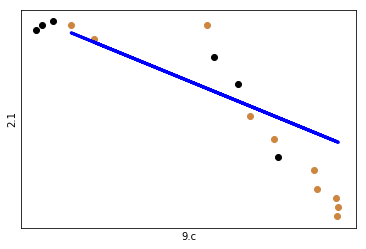

9.c 2.1
MAE: 0.87015
RMSE: 1.03376
R2: 0.588
--------------------------


17.19 9.c
MAE: 6.07967
RMSE: 7.45890
R2: 0.000
--------------------------


17.19 14.4
MAE: 68.05627
RMSE: 74.91786
R2: 0.000
--------------------------




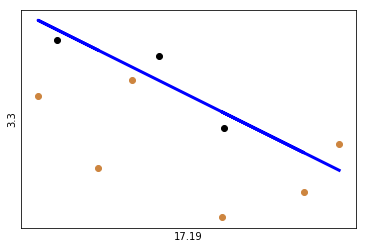

17.19 3.3
MAE: 0.78065
RMSE: 0.92274
R2: 0.000
--------------------------




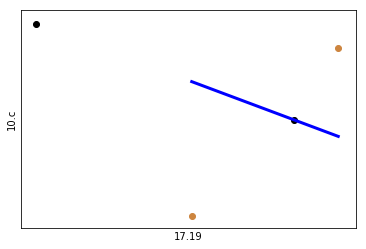

17.19 10.c
MAE: 0.46362
RMSE: 0.47335
R2: 0.000
--------------------------




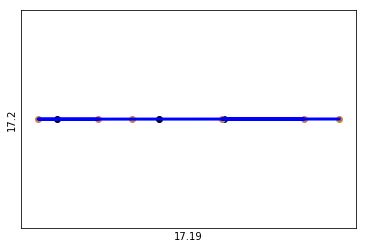

17.19 17.2
MAE: 0.00001
RMSE: 0.00001
R2: 0.000
--------------------------




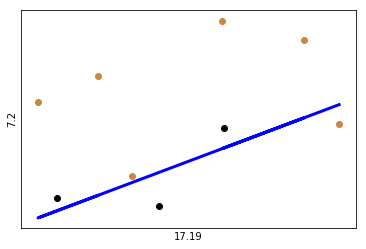

17.19 7.2
MAE: 0.60050
RMSE: 0.70768
R2: 0.000
--------------------------




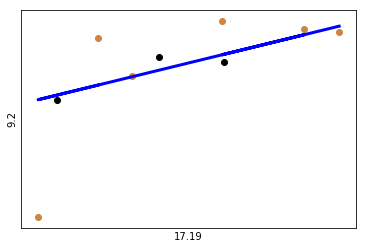

17.19 9.2
MAE: 0.18711
RMSE: 0.28415
R2: 0.390
--------------------------


9.4 17.19
MAE: 100415747.23813
RMSE: 124926179.51793
R2: 0.000
--------------------------




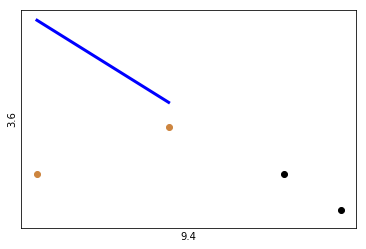

9.4 3.6
MAE: 0.15151
RMSE: 0.18698
R2: 0.000
--------------------------




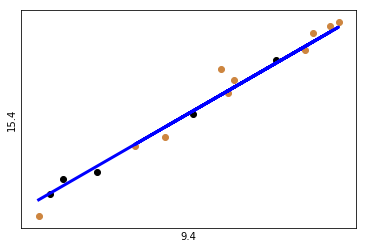

9.4 15.4
MAE: 0.45950
RMSE: 0.58603
R2: 0.965
--------------------------




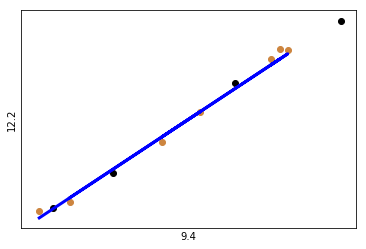

9.4 12.2
MAE: 0.05654
RMSE: 0.06495
R2: 0.992
--------------------------


9.4 9.5
MAE: 2.01323
RMSE: 2.33074
R2: 0.936
--------------------------




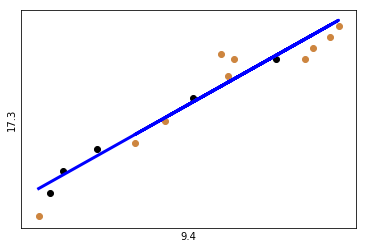

9.4 17.3
MAE: 0.02670
RMSE: 0.03146
R2: 0.901
--------------------------


9.4 4.2
MAE: 2.06609
RMSE: 2.68023
R2: 0.444
--------------------------


9.4 7.1
MAE: 1.13183
RMSE: 1.28910
R2: 0.932
--------------------------


9.4 6.1
MAE: 1.48844
RMSE: 1.91530
R2: 0.840
--------------------------




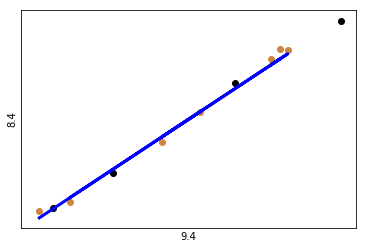

9.4 8.4
MAE: 0.05654
RMSE: 0.06495
R2: 0.992
--------------------------


9.4 8.2
MAE: 2.14809
RMSE: 2.56110
R2: 0.000
--------------------------




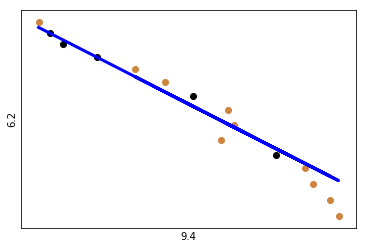

9.4 6.2
MAE: 0.64486
RMSE: 0.78685
R2: 0.918
--------------------------


9.4 15.1
MAE: 1.01569
RMSE: 1.08200
R2: 0.893
--------------------------


9.4 17.8
MAE: 3.00502
RMSE: 3.68202
R2: 0.876
--------------------------


9.4 8.1
MAE: 2.15411
RMSE: 2.63563
R2: 0.000
--------------------------


17.19 2.1
MAE: 1.30403
RMSE: 1.56675
R2: 0.000
--------------------------


17.19 15.4
MAE: 1.91461
RMSE: 2.23029
R2: 0.000
--------------------------


17.19 12.2
MAE: 0.14585
RMSE: 0.20473
R2: 0.000
--------------------------


17.19 9.5
MAE: 6.48459
RMSE: 7.59287
R2: 0.000
--------------------------




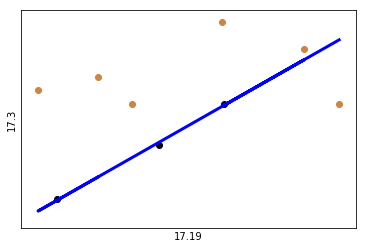

17.19 17.3
MAE: 0.05308
RMSE: 0.05913
R2: 0.000
--------------------------


17.19 4.2
MAE: 3.19776
RMSE: 3.98718
R2: 0.000
--------------------------


17.19 6.1
MAE: 2.94283
RMSE: 3.58582
R2: 0.000
--------------------------


17.19 8.4
MAE: 0.14585
RMSE: 0.20473
R2: 0.000
--------------------------


17.19 8.2
MAE: 2.38353
RMSE: 2.57384
R2: 0.000
--------------------------


17.19 6.2
MAE: 2.01016
RMSE: 2.37007
R2: 0.000
--------------------------


17.19 15.1
MAE: 1.48922
RMSE: 1.76997
R2: 0.000
--------------------------


17.19 17.8
MAE: 8.15102
RMSE: 9.68485
R2: 0.000
--------------------------


17.19 8.1
MAE: 2.40232
RMSE: 2.91276
R2: 0.000
--------------------------


14.4 9.c
MAE: 7.94146
RMSE: 11.41564
R2: 0.312
--------------------------


14.4 2.1
MAE: 1.46721
RMSE: 1.64777
R2: 0.369
--------------------------




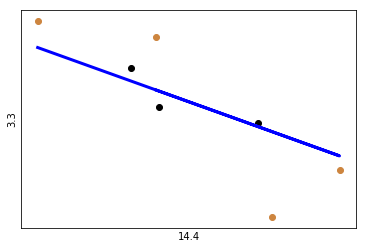

14.4 3.3
MAE: 0.57215
RMSE: 0.67063
R2: 0.610
--------------------------


17.2 14.4
MAE: 17.69811
RMSE: 22.96654
R2: 0.000
--------------------------




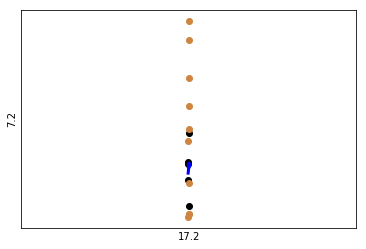

17.2 7.2
MAE: 0.47052
RMSE: 0.54961
R2: 0.000
--------------------------




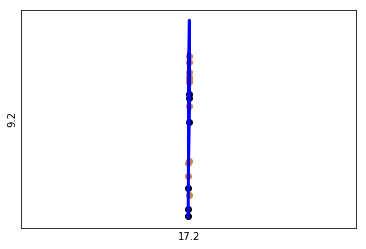

17.2 9.2
MAE: 0.21555
RMSE: 0.32916
R2: 0.366
--------------------------




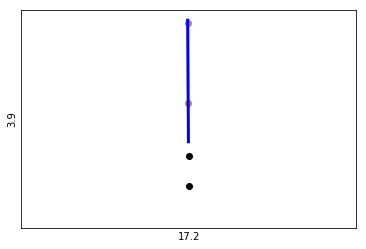

17.2 3.9
MAE: 0.00894
RMSE: 0.01181
R2: 0.545
--------------------------


17.2 14.5
MAE: 7.02134
RMSE: 8.89791
R2: 0.000
--------------------------




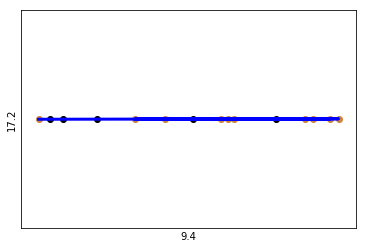

9.4 17.2
MAE: 0.00001
RMSE: 0.00001
R2: 0.575
--------------------------


17.2 3.6
MAE: 1.32860
RMSE: 1.75313
R2: 0.000
--------------------------




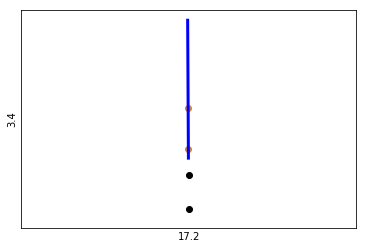

17.2 3.4
MAE: 0.07121
RMSE: 0.09159
R2: 0.000
--------------------------


17.2 15.4
MAE: 1.22603
RMSE: 1.50100
R2: 0.789
--------------------------


17.2 12.2
MAE: 0.26584
RMSE: 0.36767
R2: 0.736
--------------------------


17.2 9.5
MAE: 4.68583
RMSE: 5.67363
R2: 0.623
--------------------------




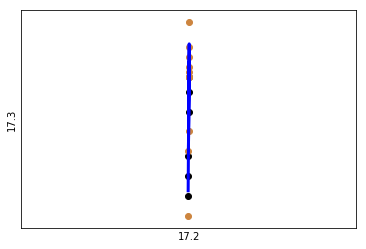

17.2 17.3
MAE: 0.03416
RMSE: 0.04238
R2: 0.853
--------------------------


17.2 16.a
MAE: 3.46218
RMSE: 3.68441
R2: 0.804
--------------------------


17.2 4.2
MAE: 2.77148
RMSE: 3.43960
R2: 0.085
--------------------------


17.2 7.1
MAE: 15.80354
RMSE: 22.14958
R2: 0.000
--------------------------


17.2 6.1
MAE: 1.42407
RMSE: 2.20014
R2: 0.797
--------------------------


17.2 8.4
MAE: 0.26584
RMSE: 0.36767
R2: 0.736
--------------------------


17.2 8.2
MAE: 2.65117
RMSE: 2.88318
R2: 0.000
--------------------------


17.2 6.2
MAE: 1.48619
RMSE: 1.87623
R2: 0.622
--------------------------


17.2 15.1
MAE: 1.15735
RMSE: 1.57730
R2: 0.780
--------------------------


17.2 17.8
MAE: 6.30160
RMSE: 8.01106
R2: 0.532
--------------------------


17.2 3.1
MAE: 3.45251
RMSE: 3.52608
R2: 0.000
--------------------------


17.2 8.1
MAE: 2.27746
RMSE: 2.67230
R2: 0.000
--------------------------


3.3 9.c
MAE: 10.14551
RMSE: 12.91404
R2: 0.000
--------------------------




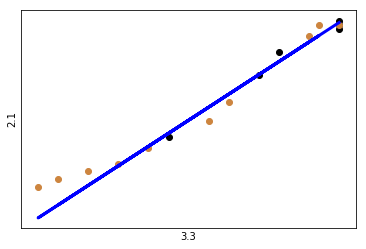

3.3 2.1
MAE: 0.29878
RMSE: 0.38773
R2: 0.942
--------------------------




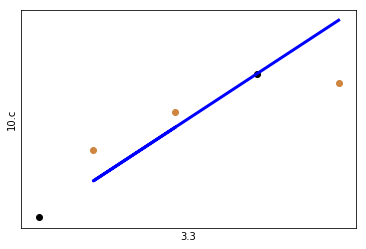

3.3 10.c
MAE: 0.38333
RMSE: 0.43625
R2: 0.000
--------------------------




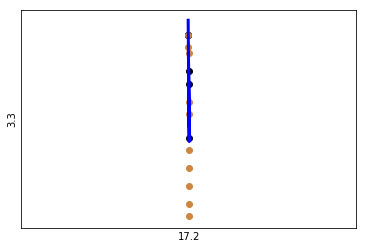

17.2 3.3
MAE: 0.65085
RMSE: 0.80625
R2: 0.418
--------------------------


10.c 9.c
MAE: 1.28444
RMSE: 1.36841
R2: 0.142
--------------------------




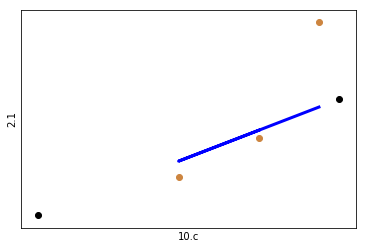

10.c 2.1
MAE: 0.18667
RMSE: 0.25923
R2: 0.418
--------------------------




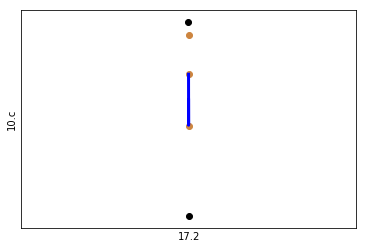

17.2 10.c
MAE: 0.16949
RMSE: 0.21057
R2: 0.461
--------------------------


17.2 9.c
MAE: 7.59411
RMSE: 11.28771
R2: 0.179
--------------------------


17.2 2.1
MAE: 1.05200
RMSE: 1.18488
R2: 0.458
--------------------------


7.2 9.c
MAE: 12.88497
RMSE: 14.50488
R2: 0.000
--------------------------




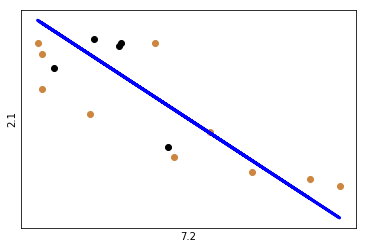

7.2 2.1
MAE: 0.96337
RMSE: 1.12397
R2: 0.446
--------------------------


7.2 14.4
MAE: 4.62045
RMSE: 5.19589
R2: 0.065
--------------------------




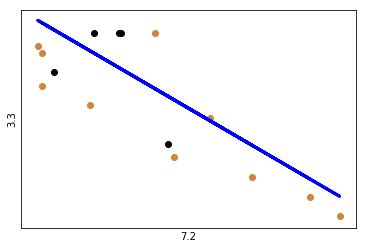

7.2 3.3
MAE: 0.54798
RMSE: 0.62374
R2: 0.570
--------------------------




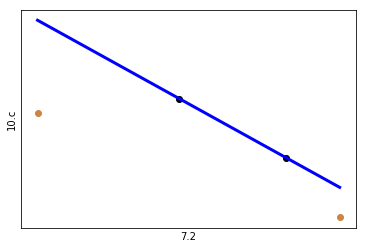

7.2 10.c
MAE: 0.41429
RMSE: 0.46642
R2: 0.000
--------------------------




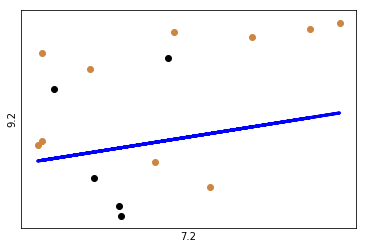

7.2 9.2
MAE: 0.42749
RMSE: 0.48180
R2: 0.000
--------------------------




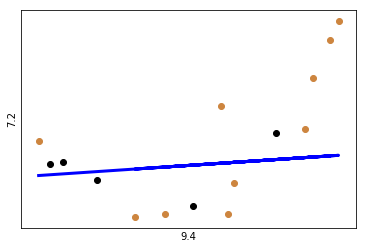

9.4 7.2
MAE: 0.45412
RMSE: 0.52319
R2: 0.000
--------------------------


9.2 9.c
MAE: 7.45481
RMSE: 10.52136
R2: 0.286
--------------------------


9.2 2.1
MAE: 1.23388
RMSE: 1.40881
R2: 0.234
--------------------------


9.2 14.4
MAE: 7.69333
RMSE: 8.31384
R2: 0.000
--------------------------




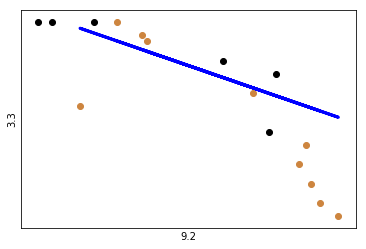

9.2 3.3
MAE: 0.76240
RMSE: 0.92724
R2: 0.230
--------------------------




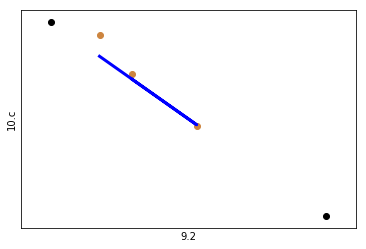

9.2 10.c
MAE: 0.07059
RMSE: 0.09808
R2: 0.883
--------------------------




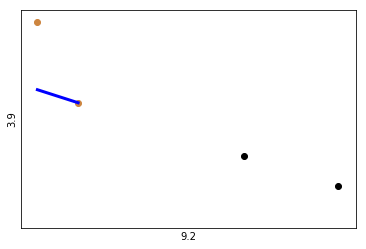

9.2 3.9
MAE: 0.01472
RMSE: 0.02079
R2: 0.000
--------------------------


9.2 14.5
MAE: 2.52467
RMSE: 3.07857
R2: 0.612
--------------------------




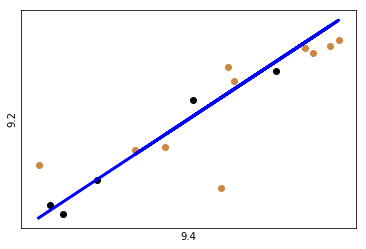

9.4 9.2
MAE: 0.17860
RMSE: 0.25148
R2: 0.566
--------------------------


3.9 9.c
MAE: 17.95500
RMSE: 19.50308
R2: 0.000
--------------------------


3.9 2.1
MAE: 1.60000
RMSE: 2.06155
R2: 0.000
--------------------------


3.9 3.3
MAE: 2.50000
RMSE: 2.96816
R2: 0.000
--------------------------


3.9 14.5
MAE: 8.82192
RMSE: 10.36739
R2: 0.000
--------------------------


14.5 9.c
MAE: 8.47353
RMSE: 11.47952
R2: 0.000
--------------------------


14.5 2.1
MAE: 1.25993
RMSE: 1.26009
R2: 0.000
--------------------------




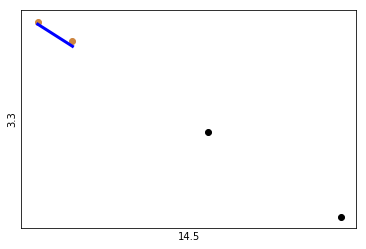

14.5 3.3
MAE: 0.05993
RMSE: 0.06310
R2: 0.823
--------------------------


9.4 9.c
MAE: 5.71027
RMSE: 9.14284
R2: 0.411
--------------------------




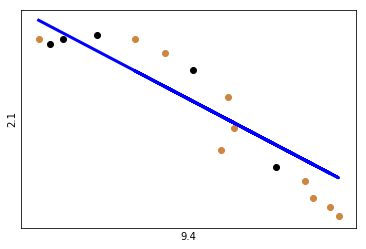

9.4 2.1
MAE: 0.61698
RMSE: 0.65529
R2: 0.812
--------------------------


9.4 14.4
MAE: 2.98159
RMSE: 3.05872
R2: 0.676
--------------------------




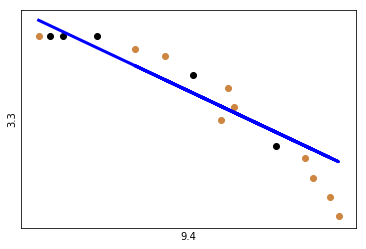

9.4 3.3
MAE: 0.36146
RMSE: 0.41971
R2: 0.805
--------------------------




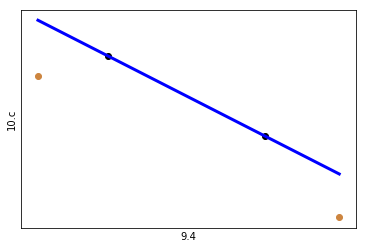

9.4 10.c
MAE: 0.24510
RMSE: 0.24728
R2: 0.501
--------------------------


3.6 9.c
MAE: 11.55167
RMSE: 11.78266
R2: 0.000
--------------------------


3.6 2.1
MAE: 2.15000
RMSE: 2.27706
R2: 0.000
--------------------------


3.6 3.3
MAE: 1.01667
RMSE: 1.22497
R2: 0.000
--------------------------




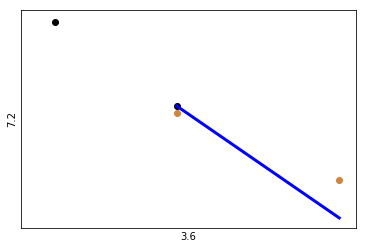

3.6 7.2
MAE: 0.18333
RMSE: 0.22096
R2: 0.330
--------------------------




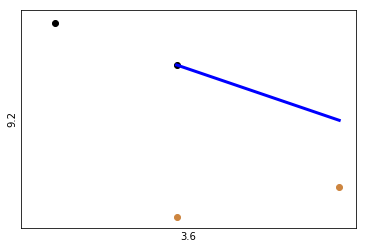

3.6 9.2
MAE: 0.47500
RMSE: 0.50975
R2: 0.000
--------------------------


3.6 15.4
MAE: 4.91500
RMSE: 5.91172
R2: 0.000
--------------------------


12.2 9.5
MAE: 1.55962
RMSE: 1.86284
R2: 0.931
--------------------------




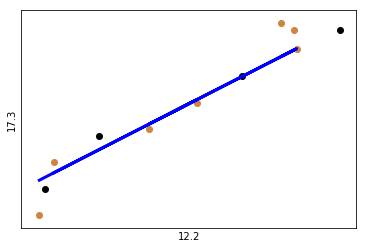

12.2 17.3
MAE: 0.02341
RMSE: 0.03089
R2: 0.907
--------------------------




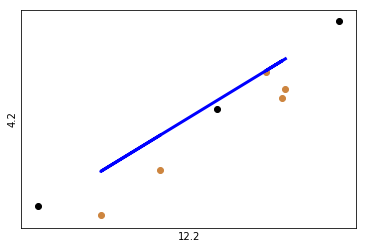

12.2 4.2
MAE: 0.59037
RMSE: 0.66179
R2: 0.644
--------------------------




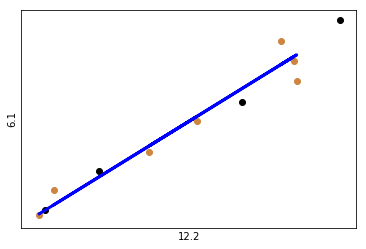

12.2 6.1
MAE: 0.88068
RMSE: 1.12618
R2: 0.940
--------------------------




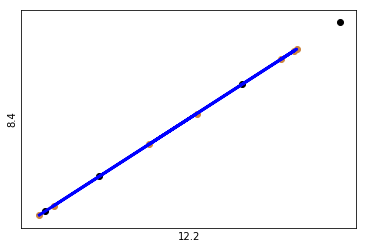

12.2 8.4
MAE: 0.00000
RMSE: 0.00000
R2: 1.000
--------------------------


12.2 8.2
MAE: 1.40239
RMSE: 2.02904
R2: 0.000
--------------------------




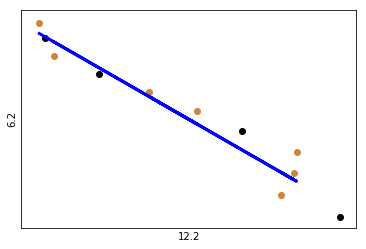

12.2 6.2
MAE: 0.45866
RMSE: 0.52640
R2: 0.919
--------------------------




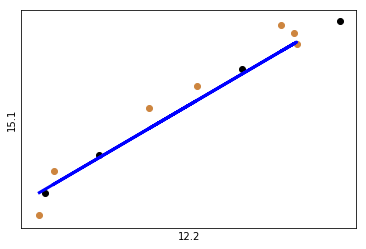

12.2 15.1
MAE: 0.80878
RMSE: 0.90077
R2: 0.933
--------------------------


12.2 17.8
MAE: 1.80928
RMSE: 2.10281
R2: 0.890
--------------------------


12.2 8.1
MAE: 1.76407
RMSE: 2.60731
R2: 0.000
--------------------------


3.4 9.c
MAE: 12.21300
RMSE: 13.60681
R2: 0.000
--------------------------




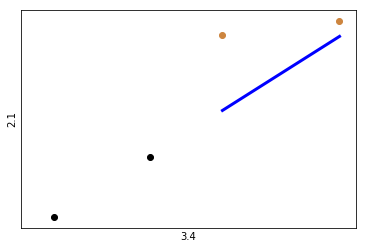

3.4 2.1
MAE: 0.96900
RMSE: 1.16293
R2: 0.000
--------------------------




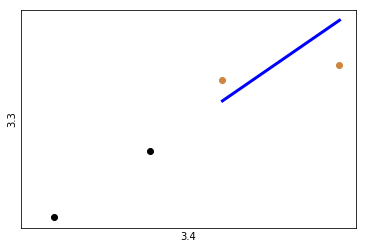

3.4 3.3
MAE: 0.64300
RMSE: 0.68323
R2: 0.000
--------------------------




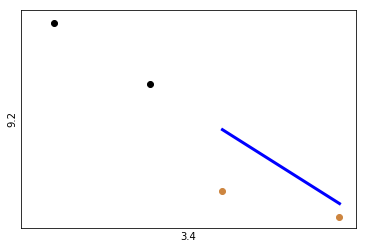

3.4 9.2
MAE: 0.18400
RMSE: 0.21859
R2: 0.000
--------------------------




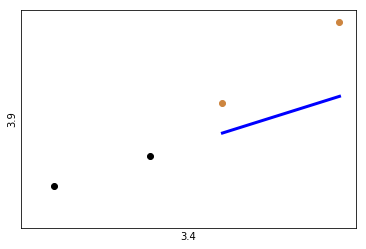

3.4 3.9
MAE: 0.02269
RMSE: 0.02463
R2: 0.000
--------------------------


3.4 14.5
MAE: 2.14780
RMSE: 2.37029
R2: 0.000
--------------------------


3.4 15.4
MAE: 3.34020
RMSE: 3.43952
R2: 0.000
--------------------------


15.4 9.c
MAE: 6.27590
RMSE: 10.26560
R2: 0.321
--------------------------




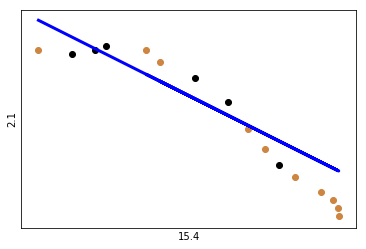

15.4 2.1
MAE: 0.67105
RMSE: 0.72869
R2: 0.795
--------------------------


15.4 14.4
MAE: 4.54812
RMSE: 4.89523
R2: 0.170
--------------------------




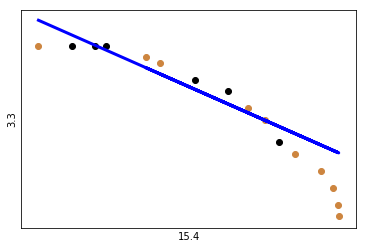

15.4 3.3
MAE: 0.44372
RMSE: 0.56159
R2: 0.717
--------------------------


15.4 10.c
MAE: 1.12527
RMSE: 1.35024
R2: 0.000
--------------------------




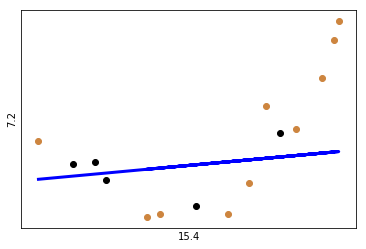

15.4 7.2
MAE: 0.44484
RMSE: 0.50866
R2: 0.000
--------------------------




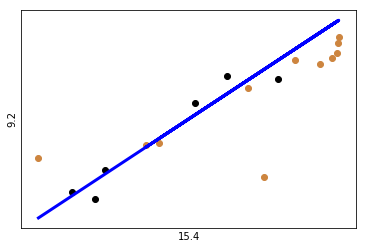

15.4 9.2
MAE: 0.24880
RMSE: 0.34972
R2: 0.285
--------------------------




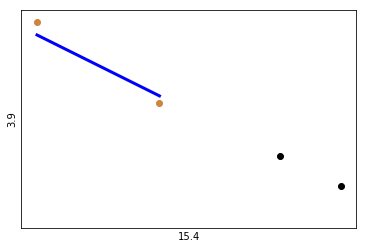

15.4 3.9
MAE: 0.00434
RMSE: 0.00456
R2: 0.932
--------------------------


15.4 14.5
MAE: 5.81000
RMSE: 7.54574
R2: 0.000
--------------------------




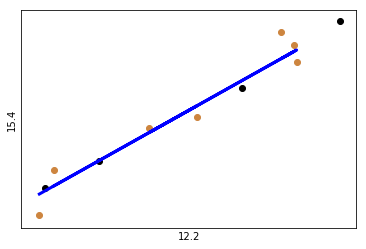

12.2 15.4
MAE: 0.59293
RMSE: 0.67092
R2: 0.936
--------------------------


12.2 9.c
MAE: 6.79867
RMSE: 10.31422
R2: 0.216
--------------------------




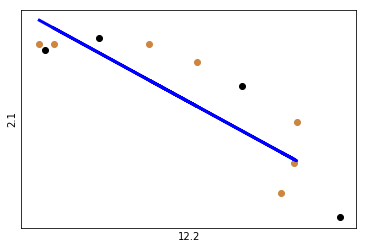

12.2 2.1
MAE: 0.49063
RMSE: 0.54200
R2: 0.694
--------------------------


12.2 14.4
MAE: 16.39333
RMSE: 18.39327
R2: 0.000
--------------------------




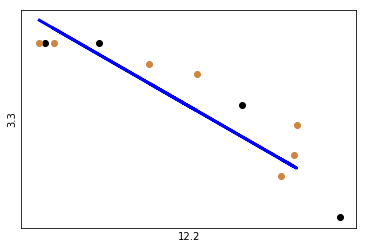

12.2 3.3
MAE: 0.23217
RMSE: 0.25615
R2: 0.732
--------------------------




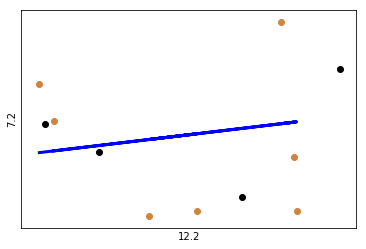

12.2 7.2
MAE: 0.28899
RMSE: 0.30758
R2: 0.000
--------------------------




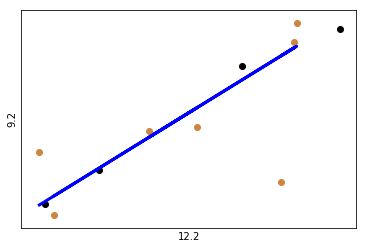

12.2 9.2
MAE: 0.19361
RMSE: 0.28633
R2: 0.321
--------------------------


9.5 9.c
MAE: 6.34837
RMSE: 9.56283
R2: 0.356
--------------------------




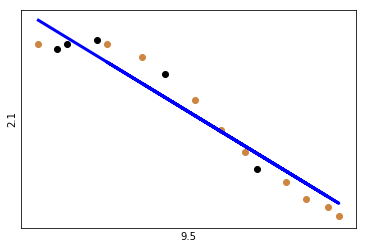

9.5 2.1
MAE: 0.32597
RMSE: 0.36794
R2: 0.941
--------------------------


9.5 14.4
MAE: 3.98871
RMSE: 4.15357
R2: 0.403
--------------------------




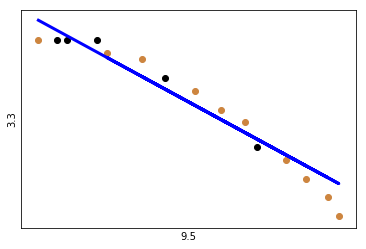

9.5 3.3
MAE: 0.23553
RMSE: 0.26711
R2: 0.921
--------------------------




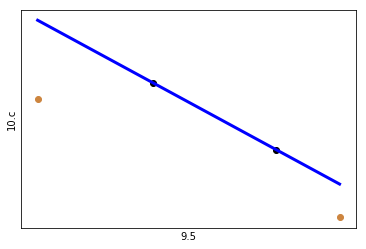

9.5 10.c
MAE: 0.33347
RMSE: 0.36098
R2: 0.000
--------------------------




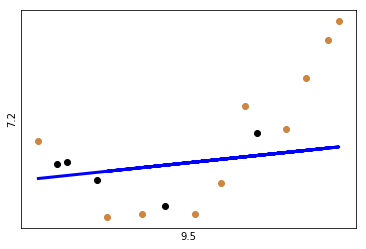

9.5 7.2
MAE: 0.43161
RMSE: 0.49249
R2: 0.060
--------------------------




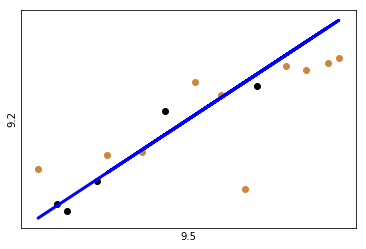

9.5 9.2
MAE: 0.25943
RMSE: 0.34670
R2: 0.174
--------------------------




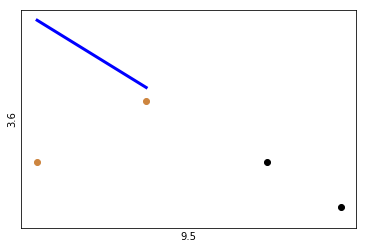

9.5 3.6
MAE: 0.10178
RMSE: 0.13208
R2: 0.000
--------------------------




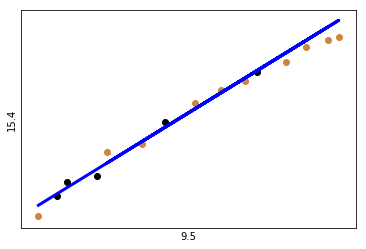

9.5 15.4
MAE: 0.46682
RMSE: 0.53774
R2: 0.971
--------------------------




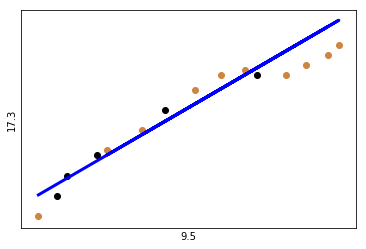

9.5 17.3
MAE: 0.03260
RMSE: 0.03713
R2: 0.862
--------------------------


9.5 4.2
MAE: 1.78286
RMSE: 2.21567
R2: 0.620
--------------------------




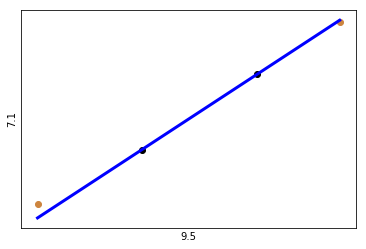

9.5 7.1
MAE: 0.43303
RMSE: 0.55507
R2: 0.987
--------------------------


9.5 6.1
MAE: 1.99813
RMSE: 2.91466
R2: 0.629
--------------------------


8.4 9.5
MAE: 1.55962
RMSE: 1.86284
R2: 0.931
--------------------------


8.4 8.2
MAE: 1.40239
RMSE: 2.02904
R2: 0.000
--------------------------




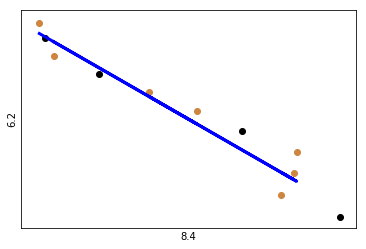

8.4 6.2
MAE: 0.45866
RMSE: 0.52640
R2: 0.919
--------------------------




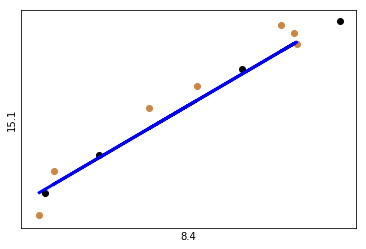

8.4 15.1
MAE: 0.80878
RMSE: 0.90077
R2: 0.933
--------------------------


8.4 17.8
MAE: 1.80928
RMSE: 2.10281
R2: 0.890
--------------------------


8.4 8.1
MAE: 1.76407
RMSE: 2.60731
R2: 0.000
--------------------------


17.3 9.c
MAE: 6.73559
RMSE: 11.09662
R2: 0.206
--------------------------




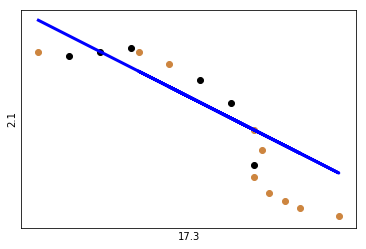

17.3 2.1
MAE: 0.88546
RMSE: 1.00326
R2: 0.612
--------------------------


17.3 14.4
MAE: 5.06583
RMSE: 5.62505
R2: 0.000
--------------------------




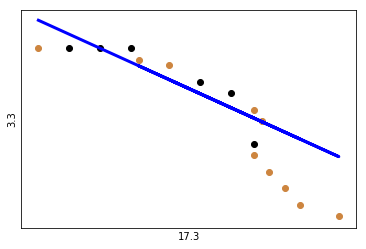

17.3 3.3
MAE: 0.57599
RMSE: 0.70788
R2: 0.551
--------------------------




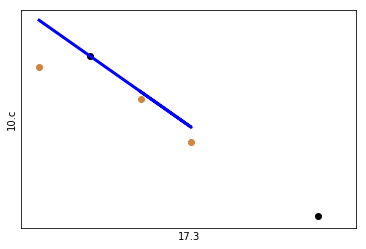

17.3 10.c
MAE: 0.21111
RMSE: 0.26458
R2: 0.149
--------------------------




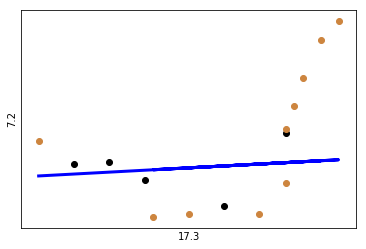

17.3 7.2
MAE: 0.46529
RMSE: 0.53873
R2: 0.000
--------------------------




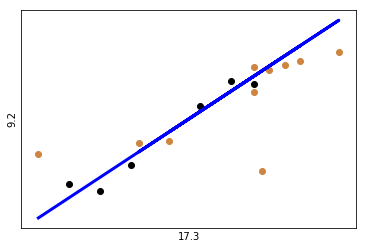

17.3 9.2
MAE: 0.25171
RMSE: 0.37586
R2: 0.139
--------------------------




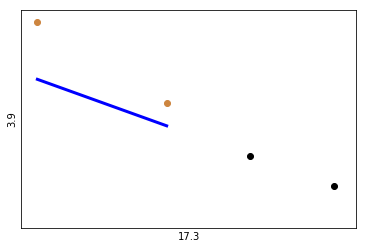

17.3 3.9
MAE: 0.01745
RMSE: 0.01898
R2: 0.000
--------------------------


17.3 14.5
MAE: 2.87682
RMSE: 4.01924
R2: 0.000
--------------------------




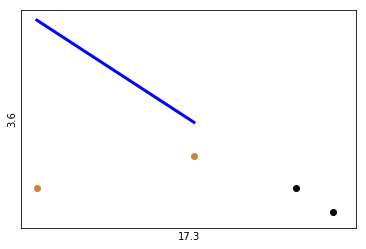

17.3 3.6
MAE: 0.25250
RMSE: 0.30301
R2: 0.000
--------------------------




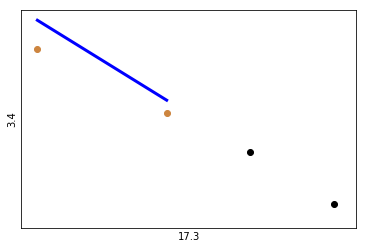

17.3 3.4
MAE: 0.02014
RMSE: 0.02172
R2: 0.493
--------------------------




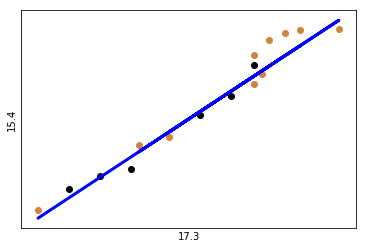

17.3 15.4
MAE: 0.70642
RMSE: 0.82979
R2: 0.937
--------------------------


17.3 16.a
MAE: 6.24091
RMSE: 7.32813
R2: 0.000
--------------------------


17.3 4.2
MAE: 2.34324
RMSE: 2.94584
R2: 0.329
--------------------------


17.3 7.1
MAE: 2.00500
RMSE: 2.44932
R2: 0.755
--------------------------


17.3 6.1
MAE: 1.57697
RMSE: 2.14046
R2: 0.808
--------------------------




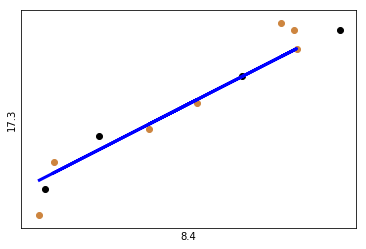

8.4 17.3
MAE: 0.02341
RMSE: 0.03089
R2: 0.907
--------------------------


16.a 9.c
MAE: 25.00500
RMSE: 29.61331
R2: 0.000
--------------------------


16.a 2.1
MAE: 2.77500
RMSE: 3.85438
R2: 0.000
--------------------------


16.a 3.3
MAE: 3.87500
RMSE: 4.76616
R2: 0.000
--------------------------




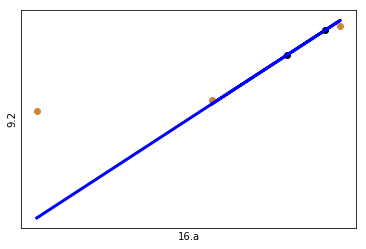

16.a 9.2
MAE: 0.45974
RMSE: 0.73293
R2: 0.000
--------------------------




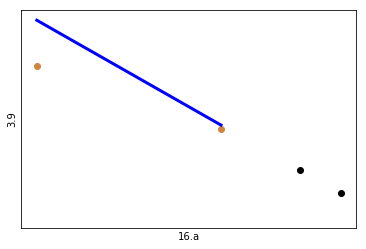

16.a 3.9
MAE: 0.01375
RMSE: 0.01809
R2: 0.000
--------------------------


16.a 14.5
MAE: 9.34128
RMSE: 13.52644
R2: 0.000
--------------------------




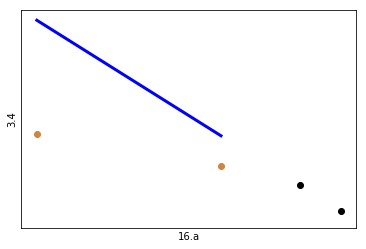

16.a 3.4
MAE: 0.14015
RMSE: 0.16238
R2: 0.000
--------------------------


16.a 15.4
MAE: 1.93487
RMSE: 2.86538
R2: 0.539
--------------------------


16.a 6.1
MAE: 14.17808
RMSE: 15.09299
R2: 0.000
--------------------------


4.2 9.c
MAE: 17.79606
RMSE: 23.86623
R2: 0.000
--------------------------


4.2 2.1
MAE: 1.39556
RMSE: 1.75735
R2: 0.000
--------------------------


4.2 14.4
MAE: 21.50550
RMSE: 26.79047
R2: 0.000
--------------------------




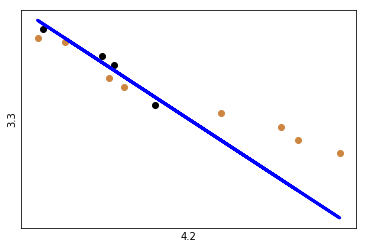

4.2 3.3
MAE: 0.66983
RMSE: 0.82818
R2: 0.176
--------------------------


4.2 10.c
MAE: 1.06071
RMSE: 1.15931
R2: 0.000
--------------------------




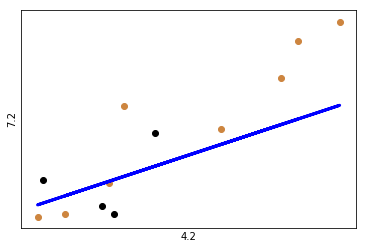

4.2 7.2
MAE: 0.30079
RMSE: 0.37834
R2: 0.475
--------------------------




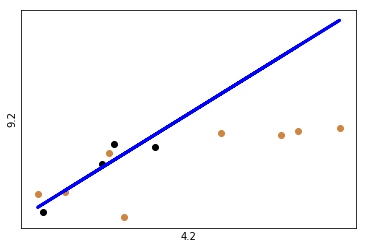

4.2 9.2
MAE: 0.58295
RMSE: 0.72443
R2: 0.000
--------------------------


4.2 15.4
MAE: 3.36500
RMSE: 4.21966
R2: 0.000
--------------------------


4.2 6.1
MAE: 7.35417
RMSE: 9.68156
R2: 0.000
--------------------------




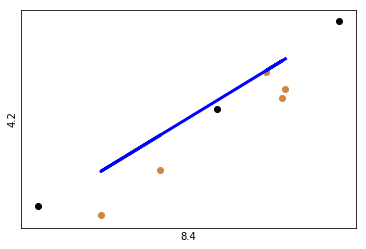

8.4 4.2
MAE: 0.59037
RMSE: 0.66179
R2: 0.644
--------------------------


7.1 9.c
MAE: 20.44436
RMSE: 23.57225
R2: 0.000
--------------------------


7.1 2.1
MAE: 1.12822
RMSE: 1.20797
R2: 0.635
--------------------------




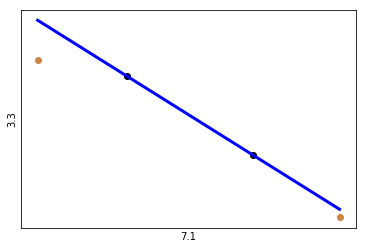

7.1 3.3
MAE: 0.41703
RMSE: 0.50479
R2: 0.870
--------------------------




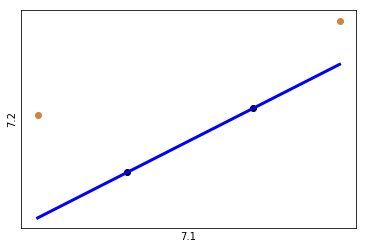

7.1 7.2
MAE: 0.68730
RMSE: 0.74286
R2: 0.000
--------------------------




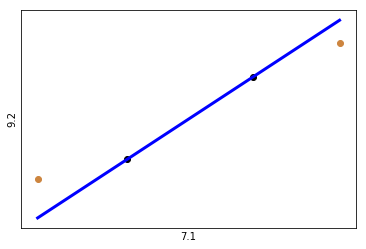

7.1 9.2
MAE: 0.19768
RMSE: 0.20426
R2: 0.784
--------------------------


7.1 15.4
MAE: 1.01549
RMSE: 1.03560
R2: 0.959
--------------------------


7.1 6.1
MAE: 3.67779
RMSE: 4.22521
R2: 0.640
--------------------------


6.1 9.c
MAE: 5.77043
RMSE: 9.04564
R2: 0.472
--------------------------




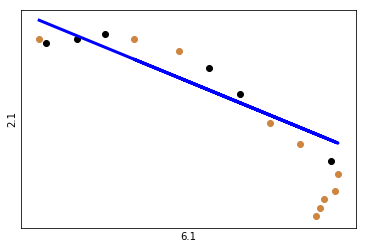

6.1 2.1
MAE: 0.91158
RMSE: 1.07950
R2: 0.550
--------------------------


6.1 14.4
MAE: 3.89825
RMSE: 4.63968
R2: 0.255
--------------------------




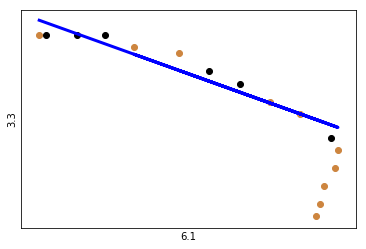

6.1 3.3
MAE: 0.57689
RMSE: 0.79686
R2: 0.431
--------------------------




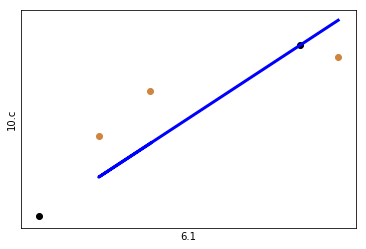

6.1 10.c
MAE: 0.37813
RMSE: 0.38277
R2: 0.000
--------------------------




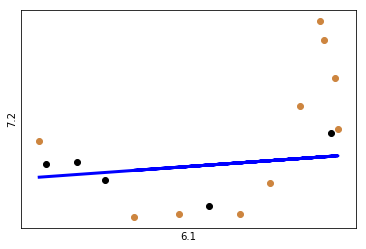

6.1 7.2
MAE: 0.45176
RMSE: 0.52282
R2: 0.000
--------------------------




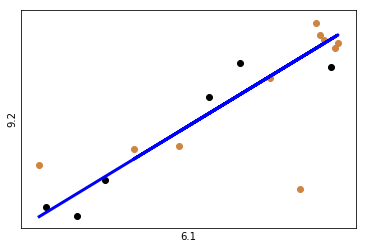

6.1 9.2
MAE: 0.18018
RMSE: 0.30952
R2: 0.416
--------------------------




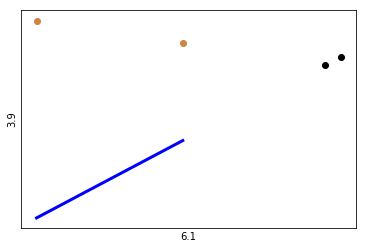

6.1 3.9
MAE: 0.23532
RMSE: 0.24828
R2: 0.000
--------------------------


6.1 14.5
MAE: 72.27446
RMSE: 75.50068
R2: 0.000
--------------------------


6.1 3.6
MAE: 2.05636
RMSE: 2.14160
R2: 0.000
--------------------------




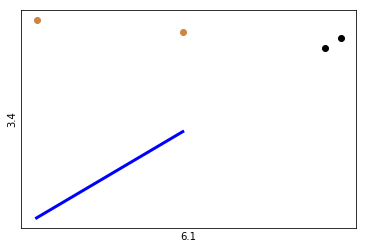

6.1 3.4
MAE: 0.81782
RMSE: 0.86051
R2: 0.000
--------------------------




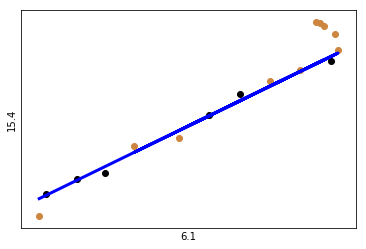

6.1 15.4
MAE: 0.92425
RMSE: 1.20350
R2: 0.867
--------------------------




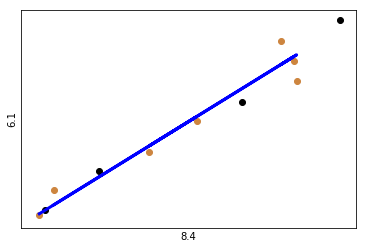

8.4 6.1
MAE: 0.88068
RMSE: 1.12618
R2: 0.940
--------------------------


8.4 9.c
MAE: 6.79867
RMSE: 10.31422
R2: 0.216
--------------------------




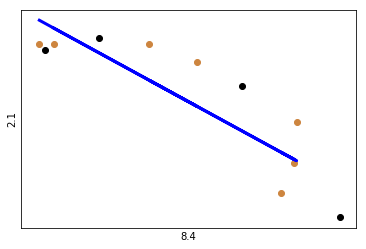

8.4 2.1
MAE: 0.49063
RMSE: 0.54200
R2: 0.694
--------------------------


8.4 14.4
MAE: 16.39333
RMSE: 18.39327
R2: 0.000
--------------------------




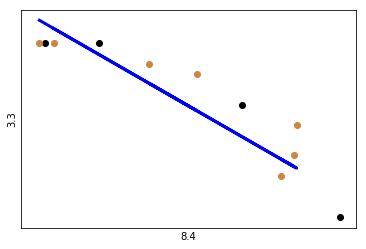

8.4 3.3
MAE: 0.23217
RMSE: 0.25615
R2: 0.732
--------------------------




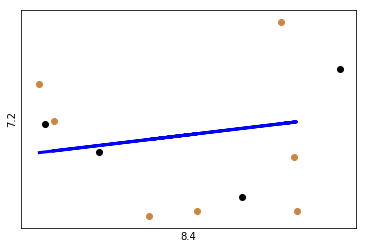

8.4 7.2
MAE: 0.28899
RMSE: 0.30758
R2: 0.000
--------------------------




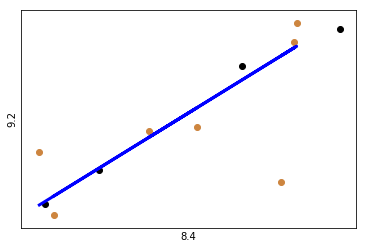

8.4 9.2
MAE: 0.19361
RMSE: 0.28633
R2: 0.321
--------------------------




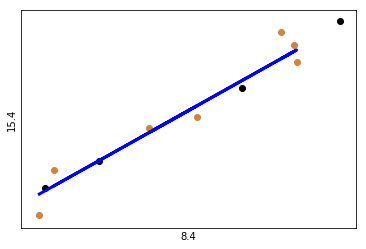

8.4 15.4
MAE: 0.59293
RMSE: 0.67092
R2: 0.936
--------------------------


8.2 9.c
MAE: 26.09273
RMSE: 29.17529
R2: 0.000
--------------------------


8.2 2.1
MAE: 2.52620
RMSE: 2.81387
R2: 0.000
--------------------------


8.2 14.4
MAE: 4.87437
RMSE: 5.56363
R2: 0.000
--------------------------


8.2 3.3
MAE: 1.57666
RMSE: 1.81147
R2: 0.000
--------------------------


8.2 10.c
MAE: 1.93333
RMSE: 2.94081
R2: 0.000
--------------------------




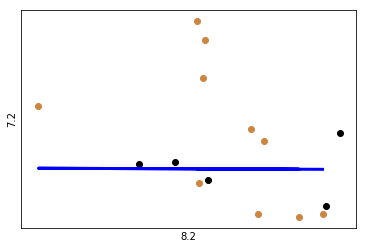

8.2 7.2
MAE: 0.47849
RMSE: 0.56758
R2: 0.000
--------------------------




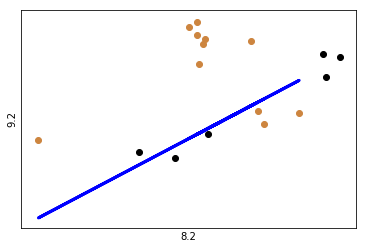

8.2 9.2
MAE: 0.70248
RMSE: 0.77797
R2: 0.000
--------------------------




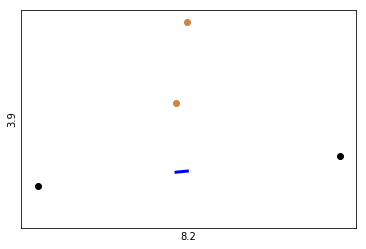

8.2 3.9
MAE: 0.04730
RMSE: 0.05035
R2: 0.000
--------------------------


8.2 14.5
MAE: 5.33933
RMSE: 6.14986
R2: 0.000
--------------------------




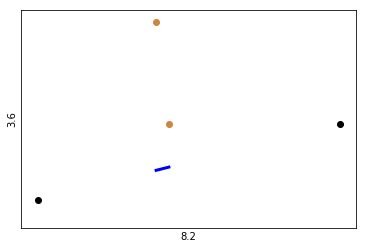

8.2 3.6
MAE: 0.07519
RMSE: 0.08576
R2: 0.000
--------------------------




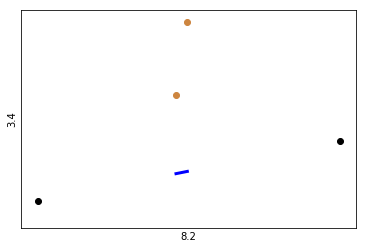

8.2 3.4
MAE: 0.09465
RMSE: 0.09916
R2: 0.000
--------------------------


8.2 15.4
MAE: 5.78088
RMSE: 6.39679
R2: 0.000
--------------------------


8.2 9.5
MAE: 13.94967
RMSE: 16.61740
R2: 0.000
--------------------------




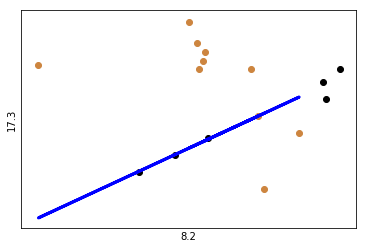

8.2 17.3
MAE: 0.18382
RMSE: 0.20785
R2: 0.000
--------------------------


8.2 16.a
MAE: 8.52000
RMSE: 11.05680
R2: 0.000
--------------------------


8.2 4.2
MAE: 5.48552
RMSE: 6.40759
R2: 0.000
--------------------------


8.2 7.1
MAE: 6.62062
RMSE: 7.44083
R2: 0.000
--------------------------


8.2 6.1
MAE: 9.18081
RMSE: 10.32229
R2: 0.000
--------------------------


8.2 6.2
MAE: 4.79071
RMSE: 5.46352
R2: 0.000
--------------------------


8.2 15.1
MAE: 6.61203
RMSE: 7.34166
R2: 0.000
--------------------------


8.2 17.8
MAE: 17.74059
RMSE: 20.31110
R2: 0.000
--------------------------


8.2 3.1
MAE: 8.41875
RMSE: 8.80925
R2: 0.000
--------------------------




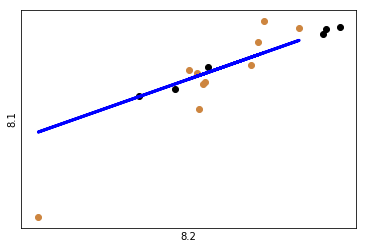

8.2 8.1
MAE: 0.68165
RMSE: 1.00865
R2: 0.639
--------------------------


6.2 9.c
MAE: 9.59454
RMSE: 12.53181
R2: 0.000
--------------------------




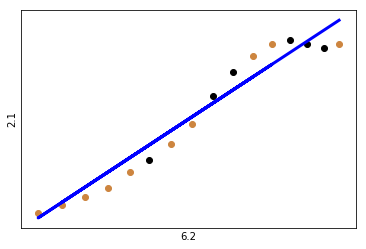

6.2 2.1
MAE: 0.33306
RMSE: 0.37378
R2: 0.946
--------------------------


6.2 14.4
MAE: 4.42596
RMSE: 4.76370
R2: 0.214
--------------------------




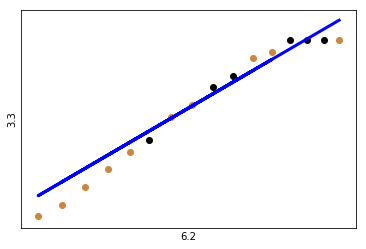

6.2 3.3
MAE: 0.21808
RMSE: 0.25149
R2: 0.943
--------------------------




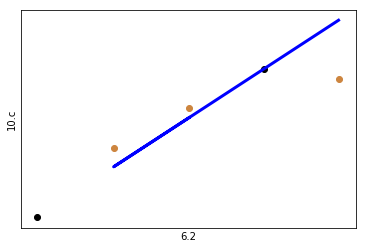

6.2 10.c
MAE: 0.29484
RMSE: 0.36390
R2: 0.000
--------------------------




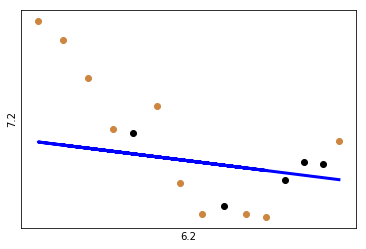

6.2 7.2
MAE: 0.42382
RMSE: 0.48049
R2: 0.105
--------------------------




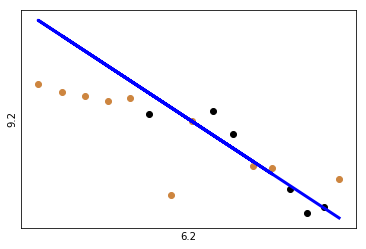

6.2 9.2
MAE: 0.35985
RMSE: 0.45373
R2: 0.000
--------------------------




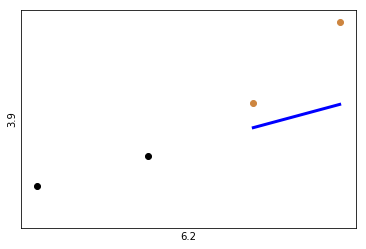

6.2 3.9
MAE: 0.02327
RMSE: 0.02640
R2: 0.000
--------------------------


6.2 14.5
MAE: 1.14619
RMSE: 1.39959
R2: 0.000
--------------------------




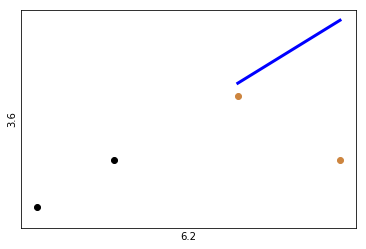

6.2 3.6
MAE: 0.09671
RMSE: 0.12542
R2: 0.000
--------------------------




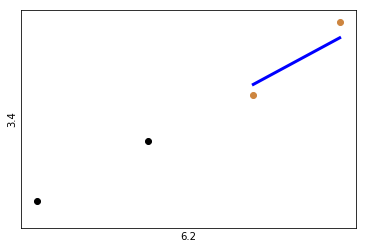

6.2 3.4
MAE: 0.01118
RMSE: 0.01140
R2: 0.860
--------------------------




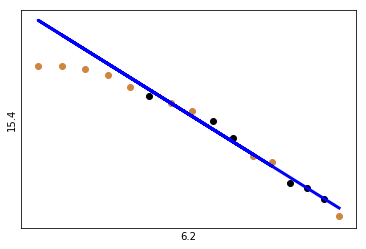

6.2 15.4
MAE: 0.92663
RMSE: 1.32022
R2: 0.839
--------------------------




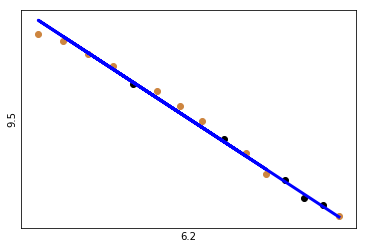

6.2 9.5
MAE: 0.82563
RMSE: 1.00827
R2: 0.988
--------------------------




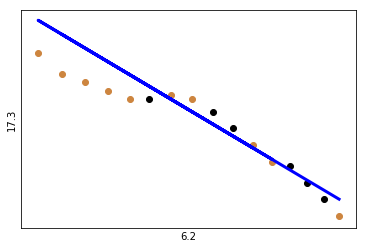

6.2 17.3
MAE: 0.04765
RMSE: 0.05714
R2: 0.732
--------------------------


6.2 16.a
MAE: 7.40374
RMSE: 8.84829
R2: 0.000
--------------------------


6.2 4.2
MAE: 1.68982
RMSE: 2.06758
R2: 0.669
--------------------------




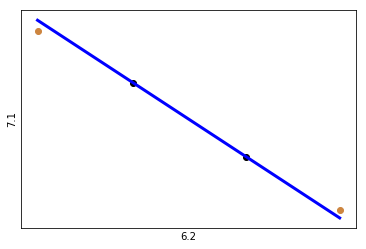

6.2 7.1
MAE: 0.52894
RMSE: 0.53594
R2: 0.988
--------------------------


6.2 6.1
MAE: 3.14231
RMSE: 4.76070
R2: 0.052
--------------------------


6.2 15.1
MAE: 2.27235
RMSE: 2.92011
R2: 0.275
--------------------------




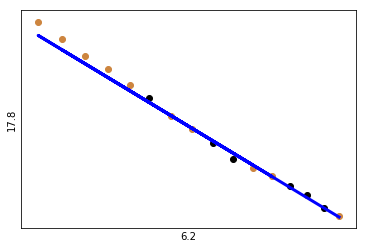

6.2 17.8
MAE: 0.99929
RMSE: 1.30971
R2: 0.987
--------------------------


6.2 3.1
MAE: 2.87355
RMSE: 3.23721
R2: 0.000
--------------------------


6.2 8.1
MAE: 2.70751
RMSE: 3.07325
R2: 0.000
--------------------------


15.1 9.c
MAE: 6.78226
RMSE: 10.68910
R2: 0.263
--------------------------


15.1 2.1
MAE: 1.04478
RMSE: 1.16272
R2: 0.479
--------------------------


15.1 14.4
MAE: 5.45409
RMSE: 6.72707
R2: 0.000
--------------------------




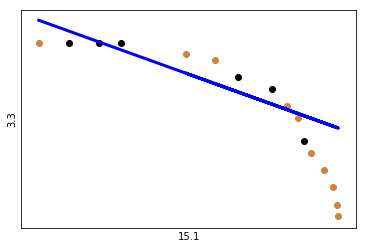

15.1 3.3
MAE: 0.65723
RMSE: 0.81561
R2: 0.404
--------------------------




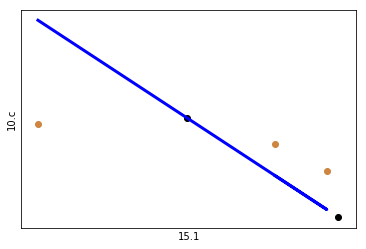

15.1 10.c
MAE: 0.87862
RMSE: 1.00705
R2: 0.000
--------------------------




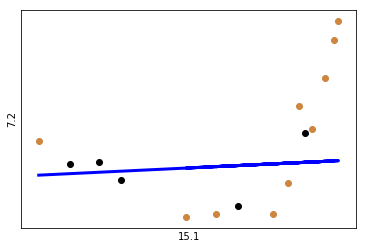

15.1 7.2
MAE: 0.46714
RMSE: 0.54122
R2: 0.000
--------------------------




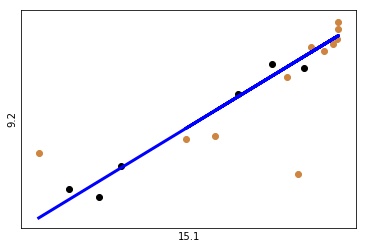

15.1 9.2
MAE: 0.18595
RMSE: 0.31509
R2: 0.419
--------------------------




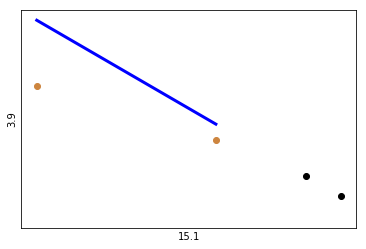

15.1 3.9
MAE: 0.02640
RMSE: 0.03082
R2: 0.000
--------------------------


15.1 14.5
MAE: 12.21985
RMSE: 17.14280
R2: 0.000
--------------------------




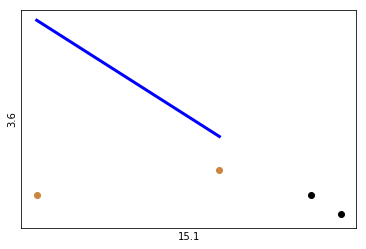

15.1 3.6
MAE: 0.33167
RMSE: 0.40110
R2: 0.000
--------------------------




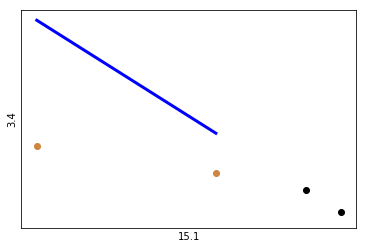

15.1 3.4
MAE: 0.18881
RMSE: 0.21271
R2: 0.000
--------------------------


15.1 15.4
MAE: 1.03843
RMSE: 1.20867
R2: 0.859
--------------------------


15.1 9.5
MAE: 3.24172
RMSE: 3.82334
R2: 0.829
--------------------------




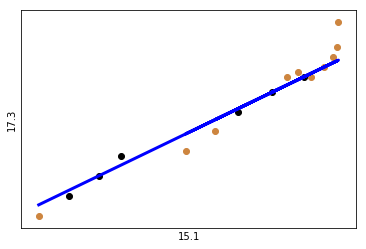

15.1 17.3
MAE: 0.02359
RMSE: 0.03094
R2: 0.921
--------------------------


15.1 16.a
MAE: 2.02000
RMSE: 2.24941
R2: 0.927
--------------------------


15.1 4.2
MAE: 2.59986
RMSE: 3.23237
R2: 0.192
--------------------------


15.1 7.1
MAE: 3.27481
RMSE: 3.82719
R2: 0.401
--------------------------




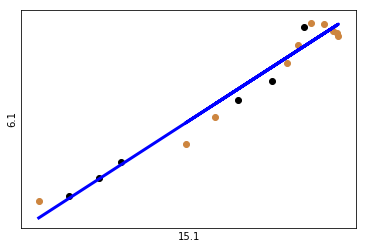

15.1 6.1
MAE: 0.96392
RMSE: 1.08564
R2: 0.951
--------------------------


15.1 17.8
MAE: 6.04403
RMSE: 7.96481
R2: 0.537
--------------------------


15.1 3.1
MAE: 8.58846
RMSE: 9.96704
R2: 0.000
--------------------------


15.1 8.1
MAE: 2.23612
RMSE: 2.69836
R2: 0.000
--------------------------


17.8 9.c
MAE: 10.54751
RMSE: 13.39527
R2: 0.000
--------------------------




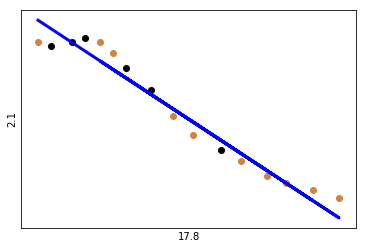

17.8 2.1
MAE: 0.32387
RMSE: 0.37259
R2: 0.946
--------------------------


17.8 14.4
MAE: 3.41472
RMSE: 3.74146
R2: 0.515
--------------------------




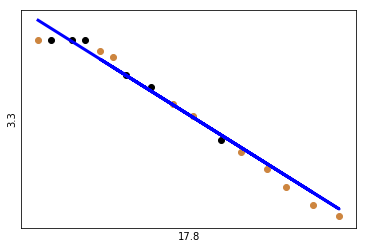

17.8 3.3
MAE: 0.13299
RMSE: 0.16187
R2: 0.977
--------------------------




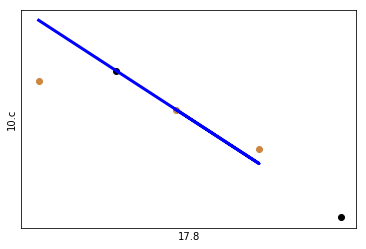

17.8 10.c
MAE: 0.25866
RMSE: 0.36947
R2: 0.000
--------------------------




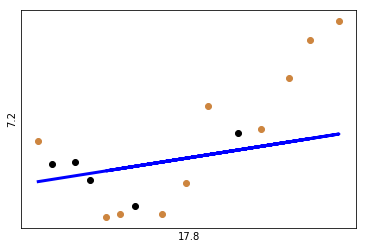

17.8 7.2
MAE: 0.40562
RMSE: 0.45604
R2: 0.194
--------------------------




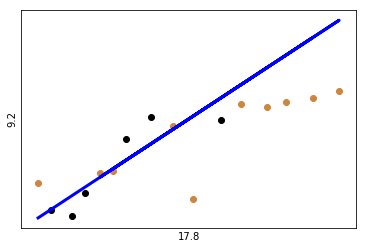

17.8 9.2
MAE: 0.37809
RMSE: 0.47428
R2: 0.000
--------------------------




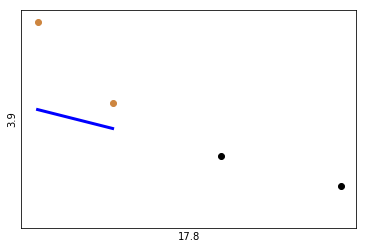

17.8 3.9
MAE: 0.02456
RMSE: 0.02799
R2: 0.000
--------------------------




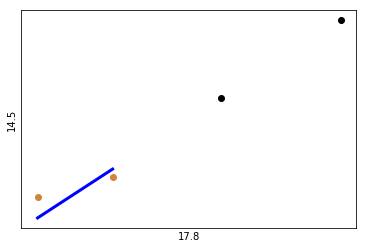

17.8 14.5
MAE: 0.82265
RMSE: 0.89713
R2: 0.000
--------------------------




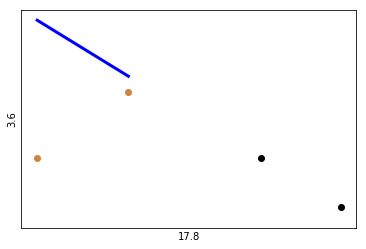

17.8 3.6
MAE: 0.09346
RMSE: 0.11933
R2: 0.000
--------------------------




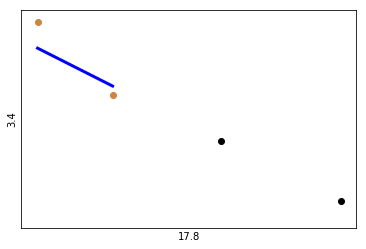

17.8 3.4
MAE: 0.01479
RMSE: 0.01645
R2: 0.709
--------------------------


17.8 15.4
MAE: 1.21679
RMSE: 1.68956
R2: 0.737
--------------------------


17.8 9.5
MAE: 1.36515
RMSE: 1.63966
R2: 0.969
--------------------------




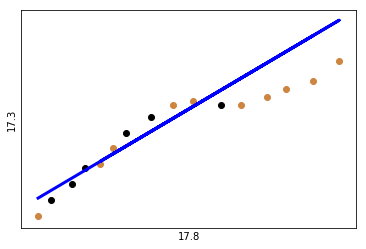

17.8 17.3
MAE: 0.05755
RMSE: 0.06842
R2: 0.616
--------------------------


17.8 16.a
MAE: 7.66216
RMSE: 9.16735
R2: 0.000
--------------------------


17.8 4.2
MAE: 1.61653
RMSE: 1.97635
R2: 0.698
--------------------------




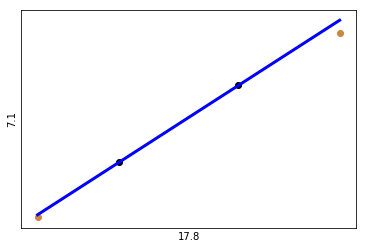

17.8 7.1
MAE: 0.38557
RMSE: 0.47530
R2: 0.991
--------------------------


17.8 6.1
MAE: 3.71379
RMSE: 5.52041
R2: 0.000
--------------------------


17.8 3.1
MAE: 3.17172
RMSE: 3.60208
R2: 0.000
--------------------------


17.8 8.1
MAE: 2.73903
RMSE: 3.09670
R2: 0.000
--------------------------


3.1 9.c
MAE: 14.34500
RMSE: 14.38905
R2: 0.000
--------------------------




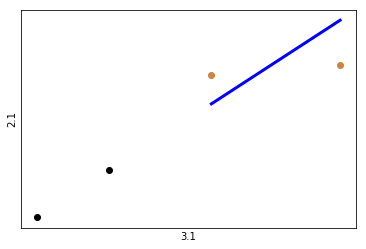

3.1 2.1
MAE: 0.99833
RMSE: 1.02193
R2: 0.000
--------------------------


3.1 3.3
MAE: 1.41833
RMSE: 1.73446
R2: 0.000
--------------------------




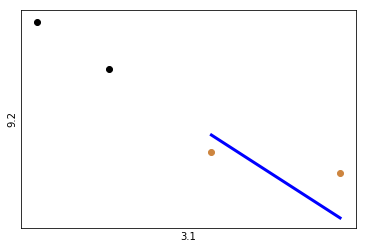

3.1 9.2
MAE: 0.20000
RMSE: 0.21932
R2: 0.000
--------------------------




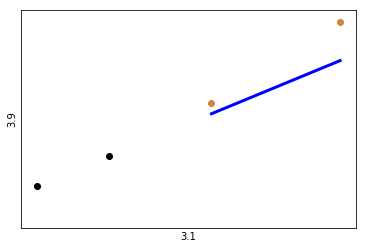

3.1 3.9
MAE: 0.01082
RMSE: 0.01238
R2: 0.500
--------------------------


3.1 14.5
MAE: 5.09433
RMSE: 6.10941
R2: 0.000
--------------------------




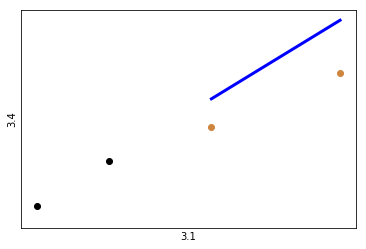

3.1 3.4
MAE: 0.04567
RMSE: 0.04767
R2: 0.000
--------------------------


3.1 15.4
MAE: 1.47700
RMSE: 1.50023
R2: 0.472
--------------------------




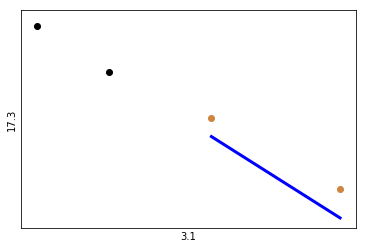

3.1 17.3
MAE: 0.05617
RMSE: 0.05747
R2: 0.543
--------------------------


3.1 16.a
MAE: 4.91333
RMSE: 6.06358
R2: 0.000
--------------------------


3.1 6.1
MAE: 12.77967
RMSE: 13.44083
R2: 0.000
--------------------------


3.1 8.1
MAE: 3.26817
RMSE: 3.38461
R2: 0.000
--------------------------


8.1 9.c
MAE: 32.97753
RMSE: 38.94340
R2: 0.000
--------------------------


8.1 2.1
MAE: 3.01558
RMSE: 3.31501
R2: 0.000
--------------------------


8.1 14.4
MAE: 4.94172
RMSE: 5.63703
R2: 0.000
--------------------------


8.1 3.3
MAE: 1.89651
RMSE: 2.10580
R2: 0.000
--------------------------




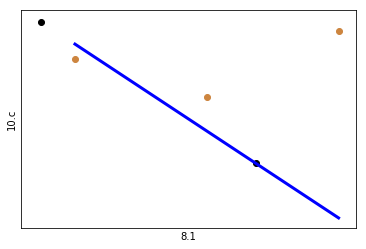

8.1 10.c
MAE: 0.83333
RMSE: 1.16527
R2: 0.000
--------------------------




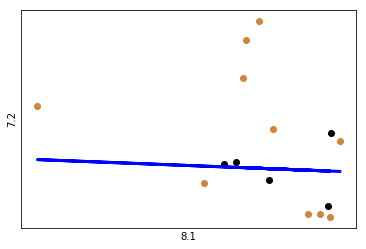

8.1 7.2
MAE: 0.47039
RMSE: 0.55860
R2: 0.000
--------------------------




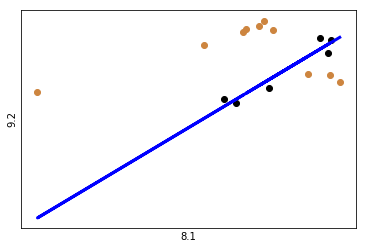

8.1 9.2
MAE: 0.93402
RMSE: 1.03181
R2: 0.000
--------------------------




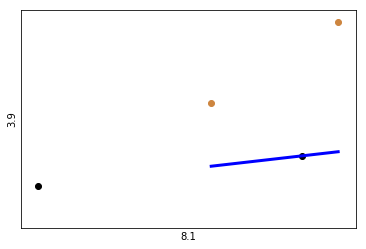

8.1 3.9
MAE: 0.04183
RMSE: 0.04423
R2: 0.000
--------------------------


8.1 14.5
MAE: 5.59281
RMSE: 5.61460
R2: 0.000
--------------------------




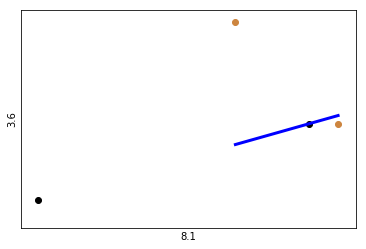

8.1 3.6
MAE: 0.05138
RMSE: 0.06819
R2: 0.000
--------------------------




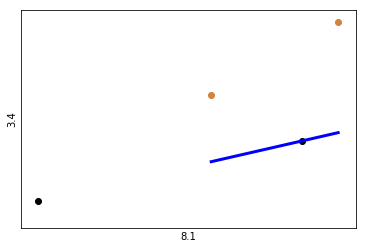

8.1 3.4
MAE: 0.07361
RMSE: 0.07589
R2: 0.000
--------------------------


8.1 15.4
MAE: 7.14420
RMSE: 8.14938
R2: 0.000
--------------------------


8.1 9.5
MAE: 18.30148
RMSE: 22.07107
R2: 0.000
--------------------------




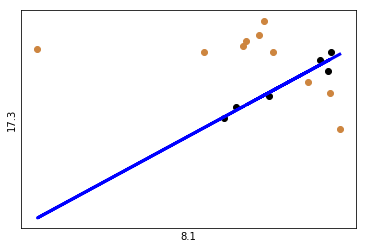

8.1 17.3
MAE: 0.23994
RMSE: 0.27942
R2: 0.000
--------------------------


8.1 16.a
MAE: 11.11569
RMSE: 12.28193
R2: 0.000
--------------------------


8.1 4.2
MAE: 7.32205
RMSE: 8.31979
R2: 0.000
--------------------------


8.1 7.1
MAE: 12.20309
RMSE: 12.69277
R2: 0.000
--------------------------


8.1 6.1
MAE: 12.16463
RMSE: 14.36933
R2: 0.000
--------------------------




In [28]:
keptPairs = list()
processedPairs = list()
notPercentTargets = ['12.2', '9.4', '8.4', '17.2', '17.19']   # work on this
highValueTargets = ['9.4', '17.19']
discardedPairs = list()

n_connections = 0

for targetx in targets:     #loop over all rows
        
        for targety in targets:    #loop over all rows except the one we're in now
            # avoid double processing of reverse pairs
            if not set([targetx, targety]) in processedPairs:
                processedPairs.extend([set([targetx, targety])])
                
                if not targety==targetx:
                    
                    if ((targety in notPercentTargets and not targetx in notPercentTargets) or targety in highValueTargets):
                        y = targetx
                        x = targety
                        targetx = x
                        targety = y


                    X = final_t_shuffled[targetx].reshape(-1,1)
                    Y = final_t_shuffled[targety].reshape(-1,1)

                    # apply mask to lists to filter out pairs containing any NaNs
                    mask = ~pd.isnull(X) & ~pd.isnull(Y)

                    X = X[mask]
                    Y = Y[mask]


                    # Split the data into training/testing sets
                    split = math.floor(2/3 * len(X))
                    X_train = X[:-split]
                    Y_train = Y[:-split]

                    X_valid = X[-split:]
                    Y_valid = Y[-split:]


                    if (len(X_train) > 1):

                        X_train = X_train.reshape(-1, 1)
                        Y_train = Y_train.reshape(-1, 1)
                        
                        X_valid = X_valid.reshape(-1, 1)
                        Y_valid = Y_valid.reshape(-1, 1)

                        linreg = linear_model.LinearRegression()
                        linreg.fit(X_train, Y_train)
                        
                        # Make predictions using the validation values
                        y_pred = linreg.predict(X_valid)
                        mae, rae, rmse, r2 = compute_error(Y_valid, y_pred)
                        
                        if targety in notPercentTargets:
                            if 0<=mae<0.1: # 1 percent tolerance (converted to tonnes)
                                #print('MAE', targetx, targety, mae)
                                keptPairs.extend([[targetx, targety]])

                                plt.scatter(X_train, Y_train,  color='black')
                                plt.scatter(X_valid, Y_valid, color='peru')
                                plt.plot(X_valid, y_pred, color='blue', linewidth=3)

                                plt.xticks(())
                                plt.yticks(())
                                plt.xlabel(targetx)
                                plt.ylabel(targety)
                                plt.show()
                                
                                n_connections = n_connections + 1
                            
                            else: discardedPairs.extend([[targetx, targety]])


                        else:
                            if 1 > mae > 0: # tolerate 1 percent error
                                keptPairs.extend([[targetx, targety]])

                                plt.scatter(X_train, Y_train,  color='black')
                                plt.scatter(X_valid, Y_valid, color='peru')
                                plt.plot(X_valid, y_pred, color='blue', linewidth=3)

                                plt.xticks(())
                                plt.yticks(())
                                plt.xlabel(targetx)
                                plt.ylabel(targety)
                                plt.show()
                                
                                n_connections = n_connections + 1
                                
                            else: discardedPairs.extend([[targetx, targety]])

                        print(targetx, targety)
                        
                        print("MAE: %.5f\nRMSE: %.5f\nR2: %.3f" % (mae, rmse, r2))
                        print('--------------------------')
                        print('\n')

#print(keptPairs)

In [29]:
print("Total number of connections found: ", n_connections)

Total number of connections found:  157


In [30]:
print(keptPairs)

[['9.c', '2.1'], ['17.19', '3.3'], ['17.19', '10.c'], ['17.19', '17.2'], ['17.19', '7.2'], ['17.19', '9.2'], ['9.4', '3.6'], ['9.4', '15.4'], ['9.4', '12.2'], ['9.4', '17.3'], ['9.4', '8.4'], ['9.4', '6.2'], ['17.19', '17.3'], ['14.4', '3.3'], ['17.2', '7.2'], ['17.2', '9.2'], ['17.2', '3.9'], ['9.4', '17.2'], ['17.2', '3.4'], ['17.2', '17.3'], ['3.3', '2.1'], ['3.3', '10.c'], ['17.2', '3.3'], ['10.c', '2.1'], ['17.2', '10.c'], ['7.2', '2.1'], ['7.2', '3.3'], ['7.2', '10.c'], ['7.2', '9.2'], ['9.4', '7.2'], ['9.2', '3.3'], ['9.2', '10.c'], ['9.2', '3.9'], ['9.4', '9.2'], ['14.5', '3.3'], ['9.4', '2.1'], ['9.4', '3.3'], ['9.4', '10.c'], ['3.6', '7.2'], ['3.6', '9.2'], ['12.2', '17.3'], ['12.2', '4.2'], ['12.2', '6.1'], ['12.2', '8.4'], ['12.2', '6.2'], ['12.2', '15.1'], ['3.4', '2.1'], ['3.4', '3.3'], ['3.4', '9.2'], ['3.4', '3.9'], ['15.4', '2.1'], ['15.4', '3.3'], ['15.4', '7.2'], ['15.4', '9.2'], ['15.4', '3.9'], ['12.2', '15.4'], ['12.2', '2.1'], ['12.2', '3.3'], ['12.2', '7.2'], ['

In [31]:
# seems like the high value targets are discarded more than the others, else, evenly distributed
print(discardedPairs)

[['17.19', '9.c'], ['17.19', '14.4'], ['9.4', '17.19'], ['9.4', '9.5'], ['9.4', '4.2'], ['9.4', '7.1'], ['9.4', '6.1'], ['9.4', '8.2'], ['9.4', '15.1'], ['9.4', '17.8'], ['9.4', '8.1'], ['17.19', '2.1'], ['17.19', '15.4'], ['17.19', '12.2'], ['17.19', '9.5'], ['17.19', '4.2'], ['17.19', '6.1'], ['17.19', '8.4'], ['17.19', '8.2'], ['17.19', '6.2'], ['17.19', '15.1'], ['17.19', '17.8'], ['17.19', '8.1'], ['14.4', '9.c'], ['14.4', '2.1'], ['17.2', '14.4'], ['17.2', '14.5'], ['17.2', '3.6'], ['17.2', '15.4'], ['17.2', '12.2'], ['17.2', '9.5'], ['17.2', '16.a'], ['17.2', '4.2'], ['17.2', '7.1'], ['17.2', '6.1'], ['17.2', '8.4'], ['17.2', '8.2'], ['17.2', '6.2'], ['17.2', '15.1'], ['17.2', '17.8'], ['17.2', '3.1'], ['17.2', '8.1'], ['3.3', '9.c'], ['10.c', '9.c'], ['17.2', '9.c'], ['17.2', '2.1'], ['7.2', '9.c'], ['7.2', '14.4'], ['9.2', '9.c'], ['9.2', '2.1'], ['9.2', '14.4'], ['9.2', '14.5'], ['3.9', '9.c'], ['3.9', '2.1'], ['3.9', '3.3'], ['3.9', '14.5'], ['14.5', '9.c'], ['14.5', '2.1'],

## 2. Build temporal model to infer missing observations

We have a temporal model with missing observations as NaNs, and want to infer them

In [32]:
# convert data to a matrix
y = df.as_matrix()
y = y[:(6*24*1)]
N, D = y.shape
print("N=%d, D=%d" % (N,D))

N=144, D=43


In [33]:
# What is observed and what is missing?

#perm1 = np.random.permutation(N)
ix_mis1 = perm1[:int(missing_perc * N)] # missing indexes
ix_obs1 = perm1[int(missing_perc * N):] # observed indexes
y_mis1 = y[ix_mis1,7]
y_obs1 = y[ix_obs1,7]

#perm2 = np.random.permutation(N)
ix_mis2 = perm2[:int(missing_perc * N)] # missing indexes
ix_obs2 = perm2[int(missing_perc * N):] # observed indexes
y_mis2 = y[ix_mis2,8]
y_obs2 = y[ix_obs2,8]

N_obs = len(ix_obs1)
N_mis = len(ix_mis1)
print("N_obs:", N_obs)
print("N_mis:", N_mis)

NameError: name 'perm1' is not defined

## Define STAN model

In [ ]:
SDG_STAN="""
data {
    int<lower = 0> N_obs;    // we might need such a variable for each observed variable because they could be different
    int<lower = 0> N_mis;    // how many do we want to infer
    int<lower = 1, upper = N_obs + N_mis> ix_obs1[N_obs];    // index for observed variable 1
    int<lower = 1, upper = N_obs + N_mis> ix_mis1[N_mis];
    int<lower = 1, upper = N_obs + N_mis> ix_obs2[N_obs];    // index for observed variable 2 -> more?
    int<lower = 1, upper = N_obs + N_mis> ix_mis2[N_mis];
    real y_obs1[N_obs];         // observed time-series data for variable 1
    real y_obs2[N_obs];         // observed time-series data for variable 2
}
parameters {
    vector[1] beta[2];            // state transition coefficients
    corr_matrix[2] Omega;    // 2 because of two observed variables -> in our case 
    vector<lower=0>[2] tau;
    real<lower=0> sigma;       // observation noise
    matrix[T,2] z;             // vector of latent states
    real y_mis1[N_mis];        // missing time-series data (to infer) -> for variable 1
    real y_mis2[N_mis];        // missing time-series data (to infer) -> for variable 2 -> more?
}
model {
    for(i in 1:2)                   // 2 again because of two observed variables -> more?
        beta[i] ~ normal(0,1);            // prior on the auto-regressive coefficients
    tau ~ cauchy(0,1);
    Omega ~ lkj_corr(10.0);         // STAN manual Section 63.1  
    sigma ~ cauchy(0,1);            // prior on the variance
    
    z[1,:] ~ normal(0,1);           // prior on first state
    for(t in 2:T) {
        vector[2] mu;
        mu[1] = beta[1]' * z[(t-1):(t-1),1];
        mu[2] = beta[2]' * z[(t-1):(t-1),2];
        z[t,:] ~ multi_normal(mu, quad_form_diag(Omega, tau)); // latent dynamics
    }
    
    y1 ~ normal(z[:,1], sigma);    // likelihood
    y2 ~ normal(z[:,2], sigma);    // likelihood -> more variables?
}
"""

In [ ]:
# prepare data for STAN model
data = {'N_obs': N_obs, 'N_mis': N_mis, 
        'ix_obs1': ix_obs1+1, 'ix_mis1': ix_mis1+1, 'y_obs1': y_obs1, 
        'ix_obs2': ix_obs2+1, 'ix_mis2': ix_mis2+1, 'y_obs2': y_obs2}

# add more ix_obs3, etc. if we take more variables to infer

In [ ]:
%%time
# create STAN model object (compile STAN model)
sm = pystan.StanModel(model_code=SDG_STAN)

In [ ]:
# run inference using MCMC sampling
fit = sm.sampling(data=data, iter=500, chains=4, algorithm="NUTS", seed=42, verbose=True)
print(fit)

In [ ]:
samples = fit.extract(permuted=True)  # return a dictionary of arrays

In [ ]:
fit.plot(["tau","sigma","lp__"]) # take vars from temporal model
plt.show()

#### Compute mean and standard devitions for the imputed values of the time-series and visualize them (in comparison with the corresponding true values):

In [ ]:
# get mean and standard devitions for predictions
y_hat = samples["y_mis1"].mean(axis=0)
y_std = samples["y_mis1"].std(axis=0)

In [ ]:
plt.plot(ix_obs1, y_obs1, "bo")
plt.plot(ix_mis1, y_mis1, "bx")
plt.plot(ix_mis1, y_hat, "rx")
#plt.plot(ix_mis, y_hat + y_std, "r--")
#plt.plot(ix_mis, y_hat - y_std, "r--")
plt.legend(["true","forecast","forecast + stddev","forecast - stddev"])

Compute error statistics of the model's imputations:

In [ ]:
# insert def compute_error if deleted above
mae, rae, rmse, r2 = compute_error(y_mis1, y_hat) #for missing variables
print("MAE: %.5f\nRMSE: %.5f\nR2: %.3f" % (corr, mae, rmse, r2))